In [2]:
from tools import *
import pickle
import xgboost
import pandas
from scipy.optimize import curve_fit
import matplotlib as mpl
mpl.rcParams['text.usetex'] = False
from matplotlib.colors import LogNorm



with open('../MicroBooNE/Simulation.pkl', 'rb') as infile:
  data = pickle.load(infile)

In [3]:
#Let's look at the variables contained in the dataset

for variable_name in list(data):
  print(variable_name)

Distance to closest cosmic ray track
Length of lepton track
Distance to longest track
Simulation category
Topological muon ML score
End position of lepton track z component
End position of lepton track y component
End position of lepton track x component
Track vs shower ML score
Particle ID LLh
Start position of lepton track z component
Start position of lepton track y component
Start position of lepton track x component
Interaction vertex position x component
Interaction vertex position y component
Interaction vertex position z component
Total energy
Subevent
Muon momenutm (length estimate)
Muon momenutm (scattering estimate)
Simulation weight
Simulated neutrino energy
Simulated neutrino flight distance
Simulated muon momentum


In [20]:
#We will create a classifier.
#We will use the Area Under the Curve (AUC) as the figure of merit for training
#our classifier. The curve refered to is the ROC curve discussed later.
#We will stop the training early if there is no improvement for 50 trained trees
#We will train a maximum of 1000 trees (it may stop early as above)
#We will set the learning rate (how strongly the boosting attempts to correct)
#the misclassified events to 0.3
#We will set the maximum levels of splittings to 6

#NB. There are also other parameters that control the training. The values chosen are
#just to give an example of a sensible training, and are unlikely to be the ones
#that give the optimal performance. These are known as hyperparameters, and it
#is a task in itself to find the most appropriate values for them

model = xgboost.XGBClassifier(eval_metric='auc', early_stopping_rounds=50, n_estimators=1000, learning_rate=0.2, max_depth=12)

In [21]:
# define which columns to include
features = [
    'Topological muon ML score',
    'Length of lepton track',
    'Distance to longest track',
    'End position of lepton track z component',
    'End position of lepton track y component',
    'End position of lepton track x component',
    'Particle ID LLh',
    'Start position of lepton track z component',
    'Start position of lepton track y component',
    'Start position of lepton track x component',
    'Interaction vertex position x component',
    'Interaction vertex position y component',
    'Interaction vertex position z component',
    'Total energy',
    'Muon momenutm (length estimate)',
    'Muon momenutm (scattering estimate)',
    'Track vs shower ML score',
    'Subevent'
]

# convert all feature columns to numeric
for col in features:
    data[col] = pandas.to_numeric(data[col], errors='coerce')

# rebuild sig and bkg AFTER conversion

manual_selection = (data['Total energy'] < 10) & (data['Simulated neutrino flight distance'] > 100)

sig_mask = (data['Simulation category'] == 21) & manual_selection
bkg_mask = (data['Simulation category'] != 21) & manual_selection

sig = data[sig_mask]
bkg = data[bkg_mask]


# use row counts (not weights) for splitting
nSignalTotal = len(sig)
nBackgroundTotal = len(bkg)

train_frac = 0.8

nSignalTrain = int(train_frac*nSignalTotal)
nSignalTest  = nSignalTotal - nSignalTrain

nBackgroundTrain = int(train_frac*nBackgroundTotal)
nBackgroundTest  = nBackgroundTotal - nBackgroundTrain

# construct x and y
x_train = pandas.concat(
    [sig[:nSignalTrain][features], bkg[:nBackgroundTrain][features]],
    axis=0,
    ignore_index=True
)
y_train = [1]*nSignalTrain + [0]*nBackgroundTrain

x_test = pandas.concat(
    [sig[nSignalTrain:][features], bkg[nBackgroundTrain:][features]],
    axis=0,
    ignore_index=True
)
y_test  = [1]*nSignalTest + [0]*nBackgroundTest

# construct weights
w_train = pandas.concat(
    [sig[:nSignalTrain]['Simulation weight'], bkg[:nBackgroundTrain]['Simulation weight']],
    axis=0,
    ignore_index=True
)

w_test = pandas.concat(
    [sig[nSignalTrain:]['Simulation weight'], bkg[nBackgroundTrain:]['Simulation weight']],
    axis=0,
    ignore_index=True
)

# train model with weights
model.fit(
    x_train,
    y_train,
    sample_weight=w_train,
    eval_set=[(x_test, y_test)],
    sample_weight_eval_set=[w_test]
)


[0]	validation_0-auc:0.76785
[1]	validation_0-auc:0.77628
[2]	validation_0-auc:0.78437
[3]	validation_0-auc:0.78642
[4]	validation_0-auc:0.78943
[5]	validation_0-auc:0.79101
[6]	validation_0-auc:0.79212
[7]	validation_0-auc:0.79363
[8]	validation_0-auc:0.79429
[9]	validation_0-auc:0.79525
[10]	validation_0-auc:0.79608
[11]	validation_0-auc:0.79669
[12]	validation_0-auc:0.79843
[13]	validation_0-auc:0.79953
[14]	validation_0-auc:0.80025
[15]	validation_0-auc:0.80084
[16]	validation_0-auc:0.80165
[17]	validation_0-auc:0.80218
[18]	validation_0-auc:0.80216
[19]	validation_0-auc:0.80285
[20]	validation_0-auc:0.80287
[21]	validation_0-auc:0.80336
[22]	validation_0-auc:0.80364
[23]	validation_0-auc:0.80387
[24]	validation_0-auc:0.80397
[25]	validation_0-auc:0.80426
[26]	validation_0-auc:0.80464
[27]	validation_0-auc:0.80485
[28]	validation_0-auc:0.80500
[29]	validation_0-auc:0.80489
[30]	validation_0-auc:0.80512
[31]	validation_0-auc:0.80562
[32]	validation_0-auc:0.80568
[33]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=50, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

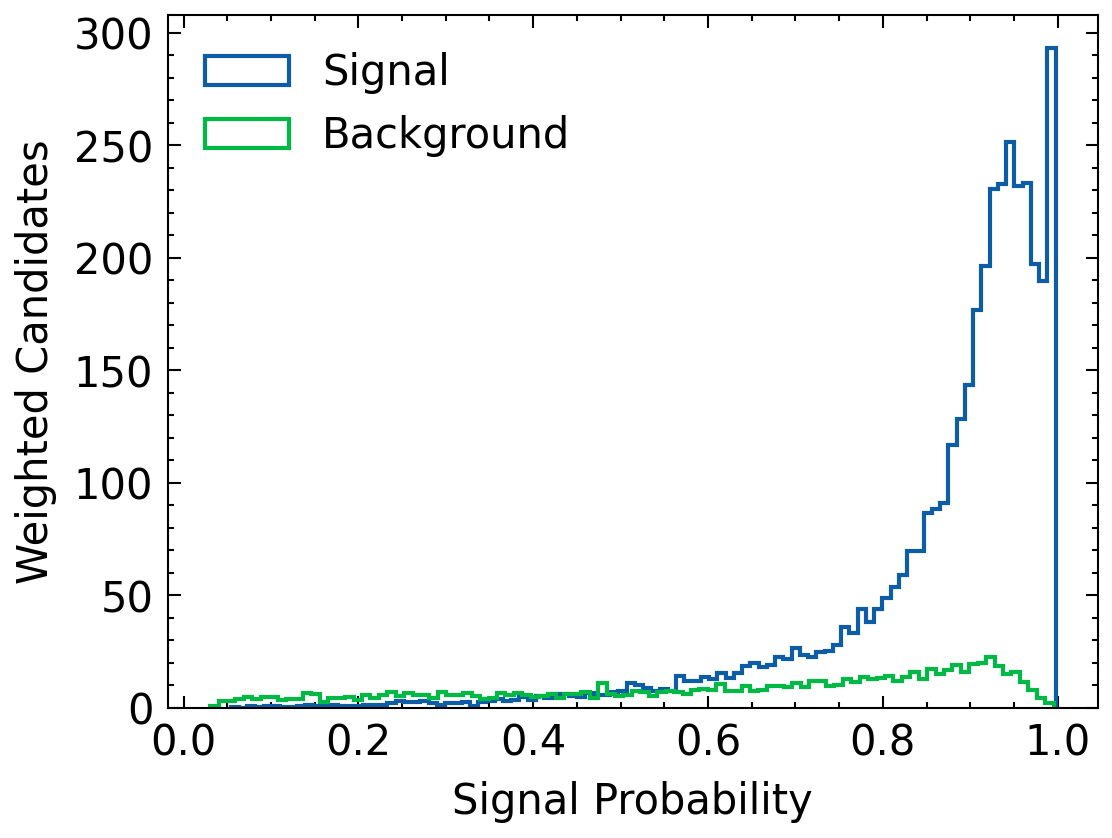

In [22]:
prediction = model.predict_proba(x_test)

# build lists of predicted probabilities with weights
sig_scores = []
sig_weights = []
bkg_scores = []
bkg_weights = []

for (p, cls, w) in zip(prediction, y_test, w_test):
    if cls == 1:
        sig_scores.append(p[1])
        sig_weights.append(w)
    else:
        bkg_scores.append(p[1])
        bkg_weights.append(w)

plt.figure(dpi=300)

plt.hist(sig_scores, bins=100, weights=sig_weights, label='Signal', alpha=1, histtype='step')
plt.hist(bkg_scores, bins=100, weights=bkg_weights, label='Background', alpha=1, histtype='step')

plt.xlabel('Signal Probability')
plt.ylabel('Weighted Candidates')
plt.legend()
plt.show()


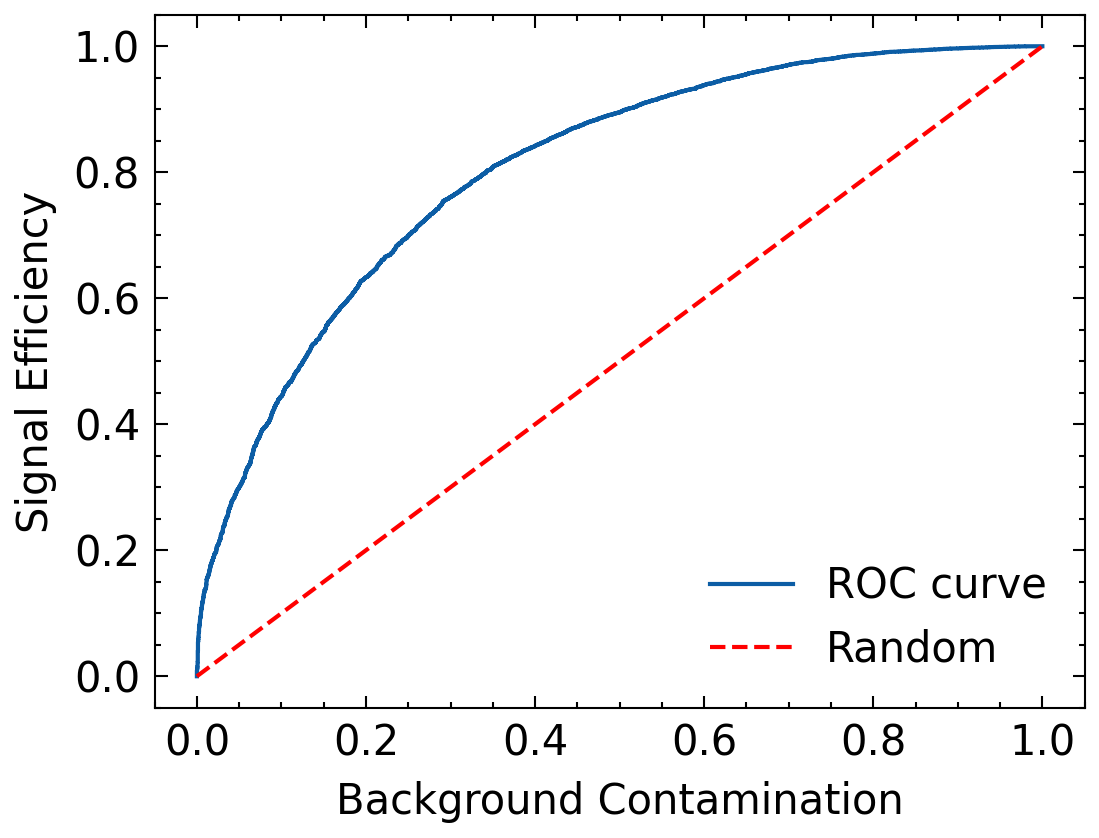

Area under curve 0.8054024545385515


In [23]:
#This clearly is now a very separating value to make a selection on.
#We can look at the performance of the algorithm in different ways.
#The next is the ROC curve, this stands for receiver operating characteristic.
#Essentially for each value of signal probability it shows the signal and
#background efficiencies, the further into the corner the better. This
#is why we chose the area under this curve as the figure of merit to train
#against. 0.5 is no better than a coin flip, 1 is perfect separation

from sklearn.metrics import roc_curve
background_accepted, signal_accepted, probabilities_tested = roc_curve(y_test, prediction[:,1])
plt.figure(dpi=300)
plt.plot(background_accepted, signal_accepted, label='ROC curve')
plt.plot([0,1], [0,1], color='red', linestyle='--', label = 'Random')
plt.xlabel('Background Contamination')
plt.ylabel('Signal Efficiency')
plt.legend()
plt.show()
print('Area under curve', np.trapz(signal_accepted, background_accepted))

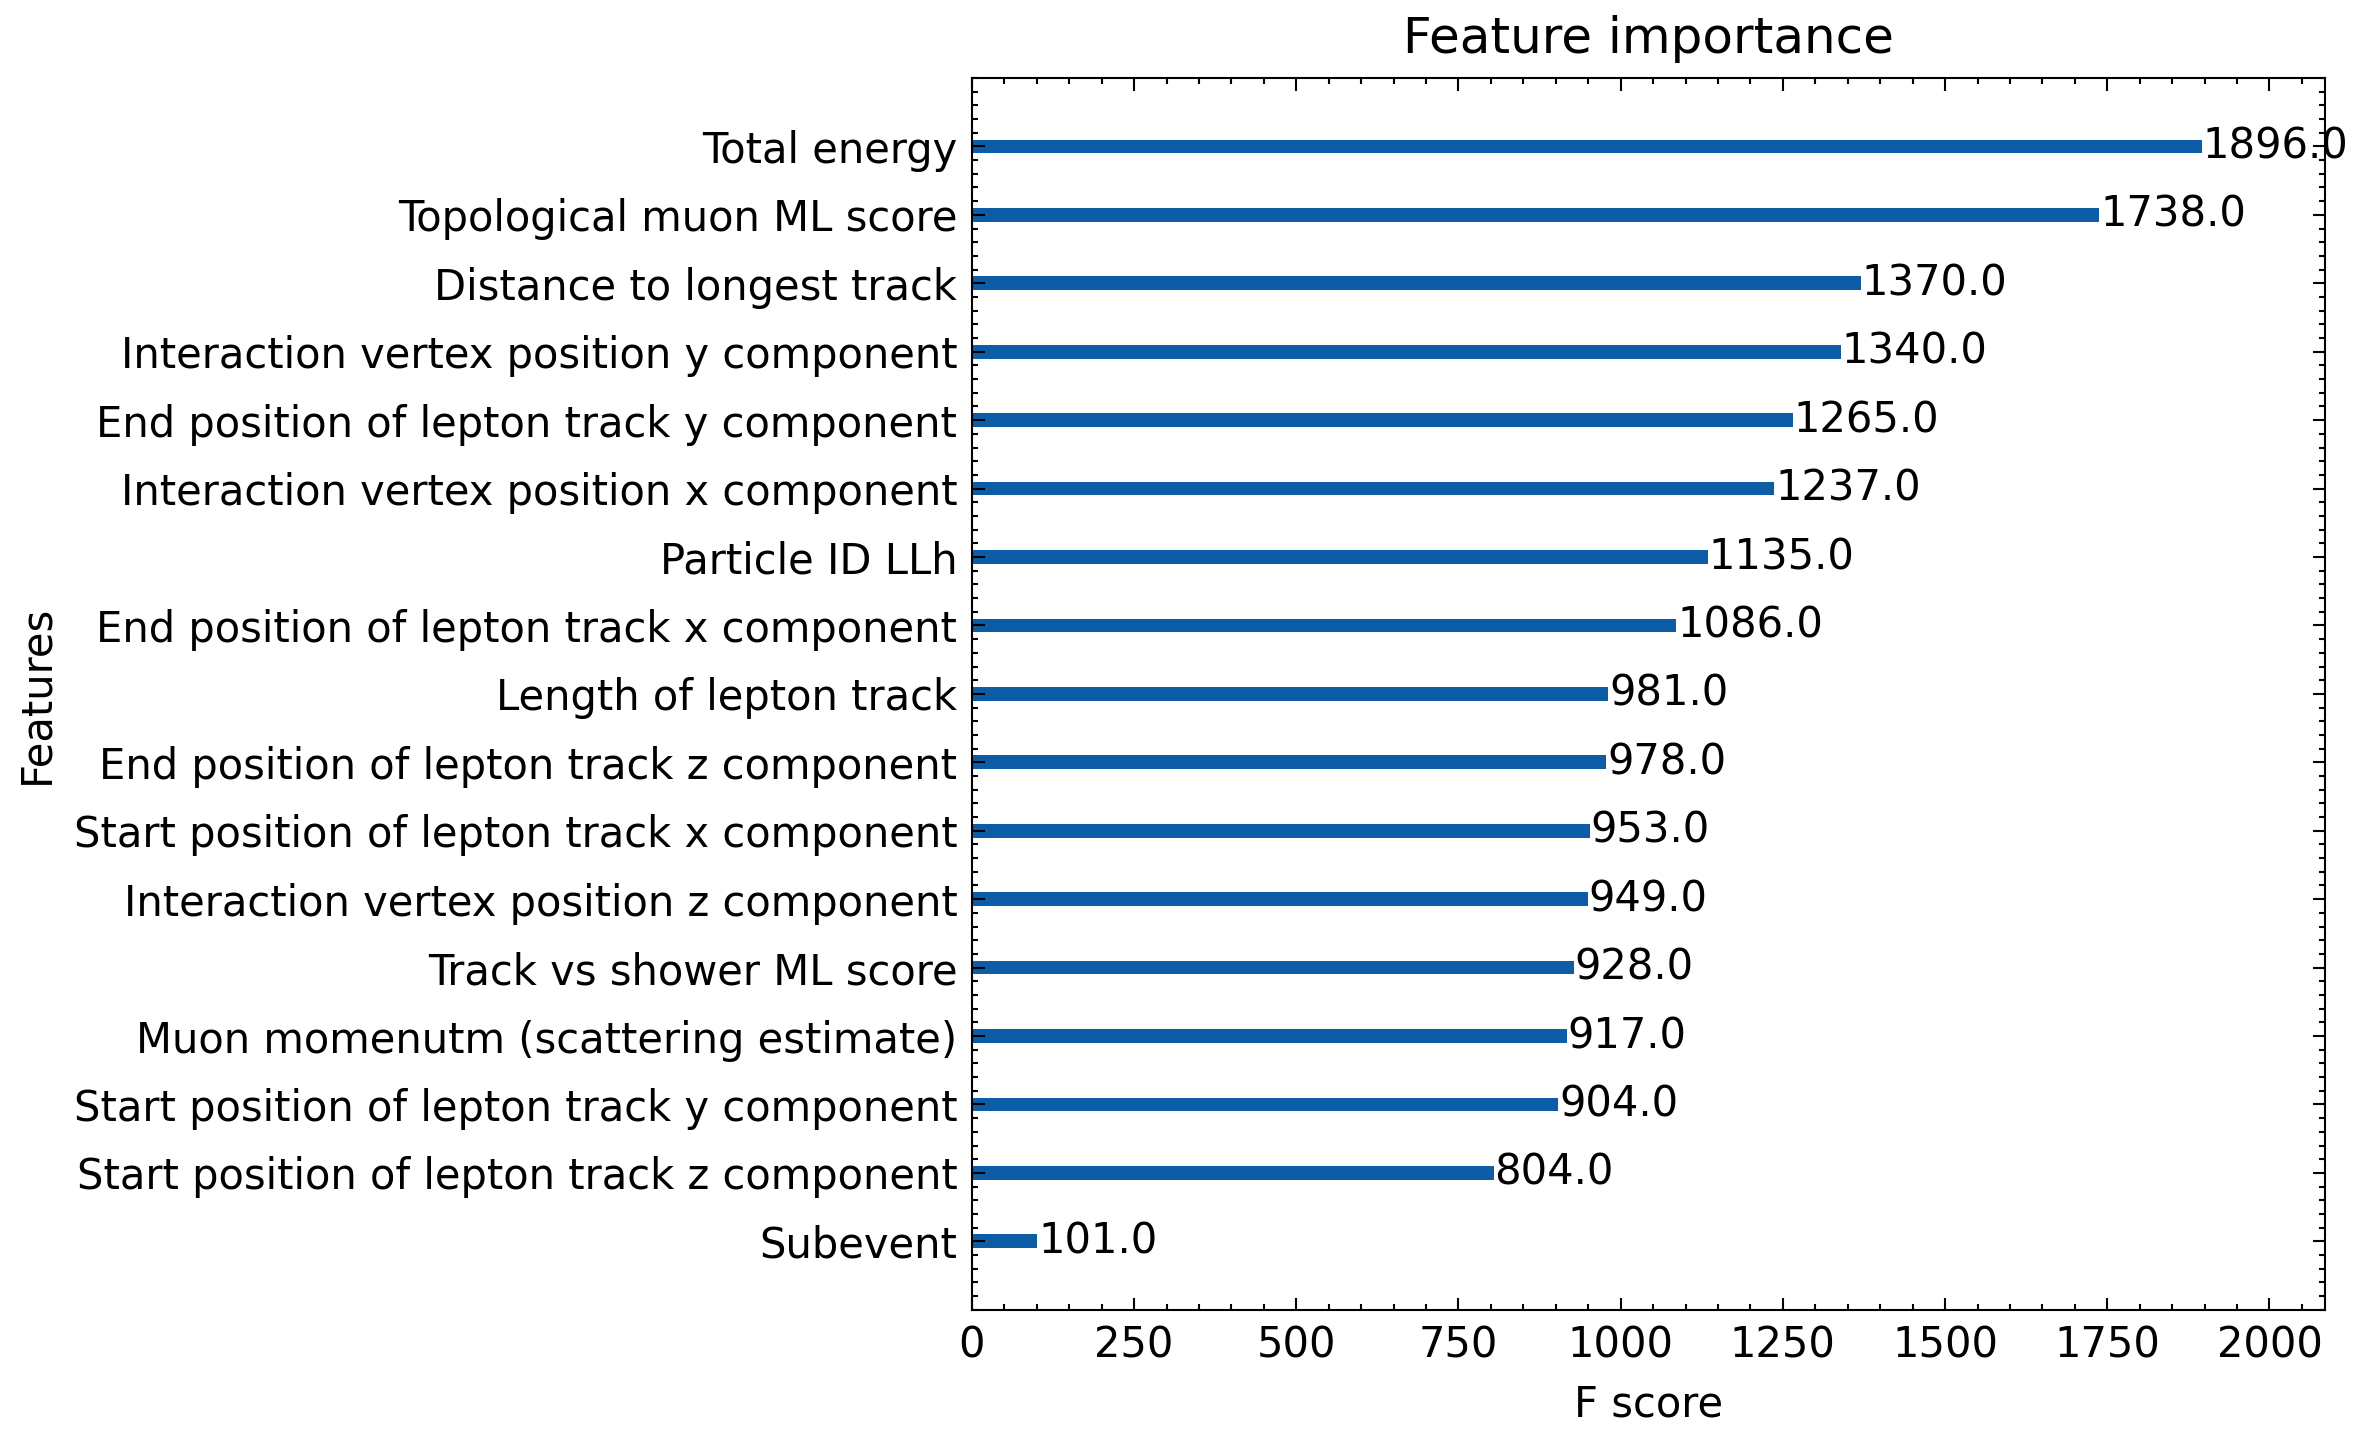

In [24]:
#Another useful diagnostic is to look at which of the variables are most useful
#in the clasificaton. Here it is academic, but it is important to think
#whether the relative importance makes sense. If not it could indicate
#something has gone wrong with the training

fig, ax = plt.subplots(figsize=(8,5), dpi=300)

xgboost.plot_importance(model, ax=ax, grid=False)

plt.tight_layout()
plt.show()


# Let's compare the reconstructed energy of the test data vs experiment

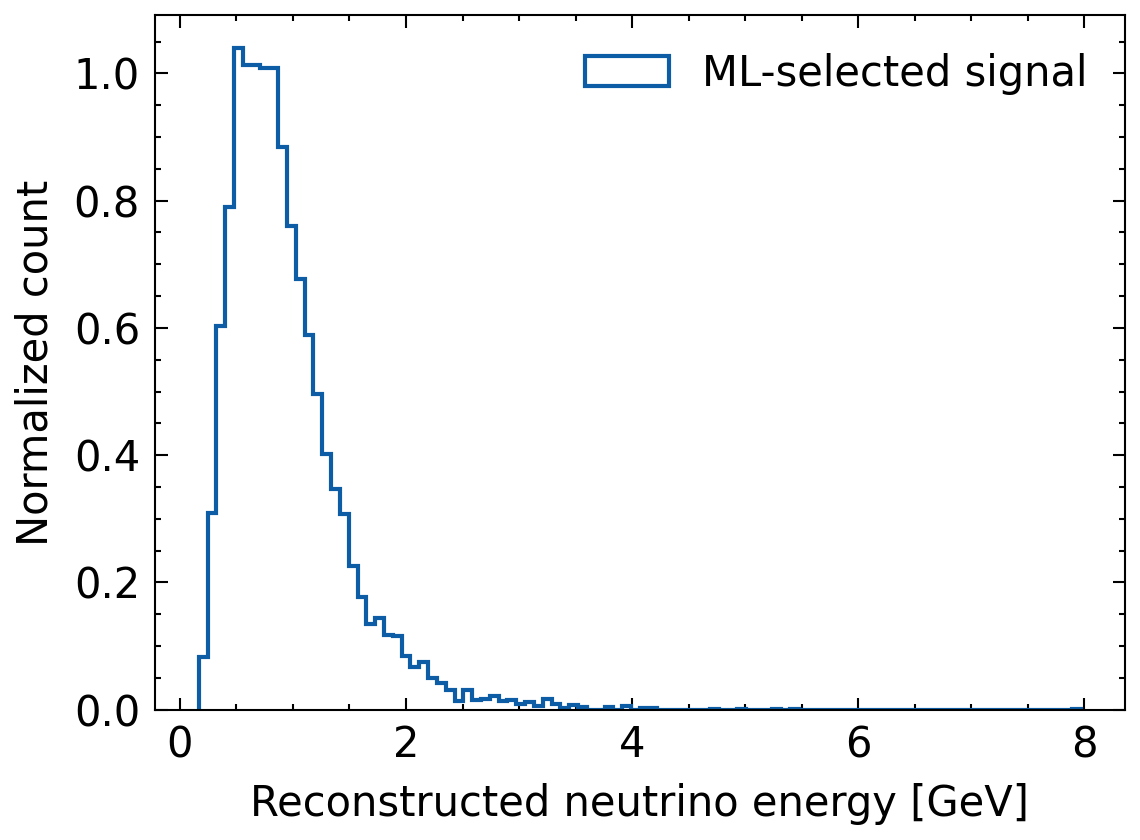

In [9]:
# model prediction on test features
prediction = model.predict_proba(x_test)
scores = prediction[:, 1]    # probability of being signal

# rebuild the real test data (physics variables, untouched)
sig_test = sig[nSignalTrain:].reset_index(drop=True)
bkg_test = bkg[nBackgroundTrain:].reset_index(drop=True)

data_test = pandas.concat([sig_test, bkg_test], axis=0, ignore_index=True)

# extract true physics variables and weights
energy_test  = data_test['Total energy'].to_numpy()
weight_test  = data_test['Simulation weight'].to_numpy()

# classifier threshold
threshold = 0.5

# events classified as signal by the model
energy_sig_like  = energy_test[scores > threshold]
weight_sig_like  = weight_test[scores > threshold]

# plot weighted histogram
plt.figure(dpi=300)
plt.hist(
    energy_sig_like,
    bins=100,
    weights=weight_sig_like,
    histtype='step',
    label='ML-selected signal',
    density = True
)

plt.xlabel('Reconstructed neutrino energy [GeV]')
plt.ylabel('Normalized count')
plt.legend()
plt.tight_layout()
plt.show()


# Using curve_fit

In [10]:
with open('../MicroBooNE/OscillatedSimulation.pkl', 'rb') as infile:
  data_exp = pickle.load(infile)

In [11]:
for variable_name in list(data_exp):
  print(variable_name)


Distance to closest cosmic ray track
Length of lepton track
Distance to longest track
Simulation category
Topological muon ML score
End position of lepton track z component
End position of lepton track y component
End position of lepton track x component
Track vs shower ML score
Particle ID LLh
Start position of lepton track z component
Start position of lepton track y component
Start position of lepton track x component
Interaction vertex position x component
Interaction vertex position y component
Interaction vertex position z component
Total energy
Muon momenutm (length estimate)
Muon momenutm (scattering estimate)
Simulation weight
Simulated neutrino energy
Simulated neutrino flight distance
Simulated muon momentum


In [12]:
def calculate_prob(sin2, dm2, L, E):
    # E in GeV, dm2 in eV^2, L in km
    term = 1.27 * dm2 * L / E
    return 1 - sin2 * np.sin(term)**2

Best-fit sin²: 0.4828208057196181 ± 0.059761649845719585
Best-fit Δm²: 16.145534173081277 ± 0.38812315300976913
χ²: 8.044548744859624
ndf: 8
Reduced χ²: 1.005568593107453


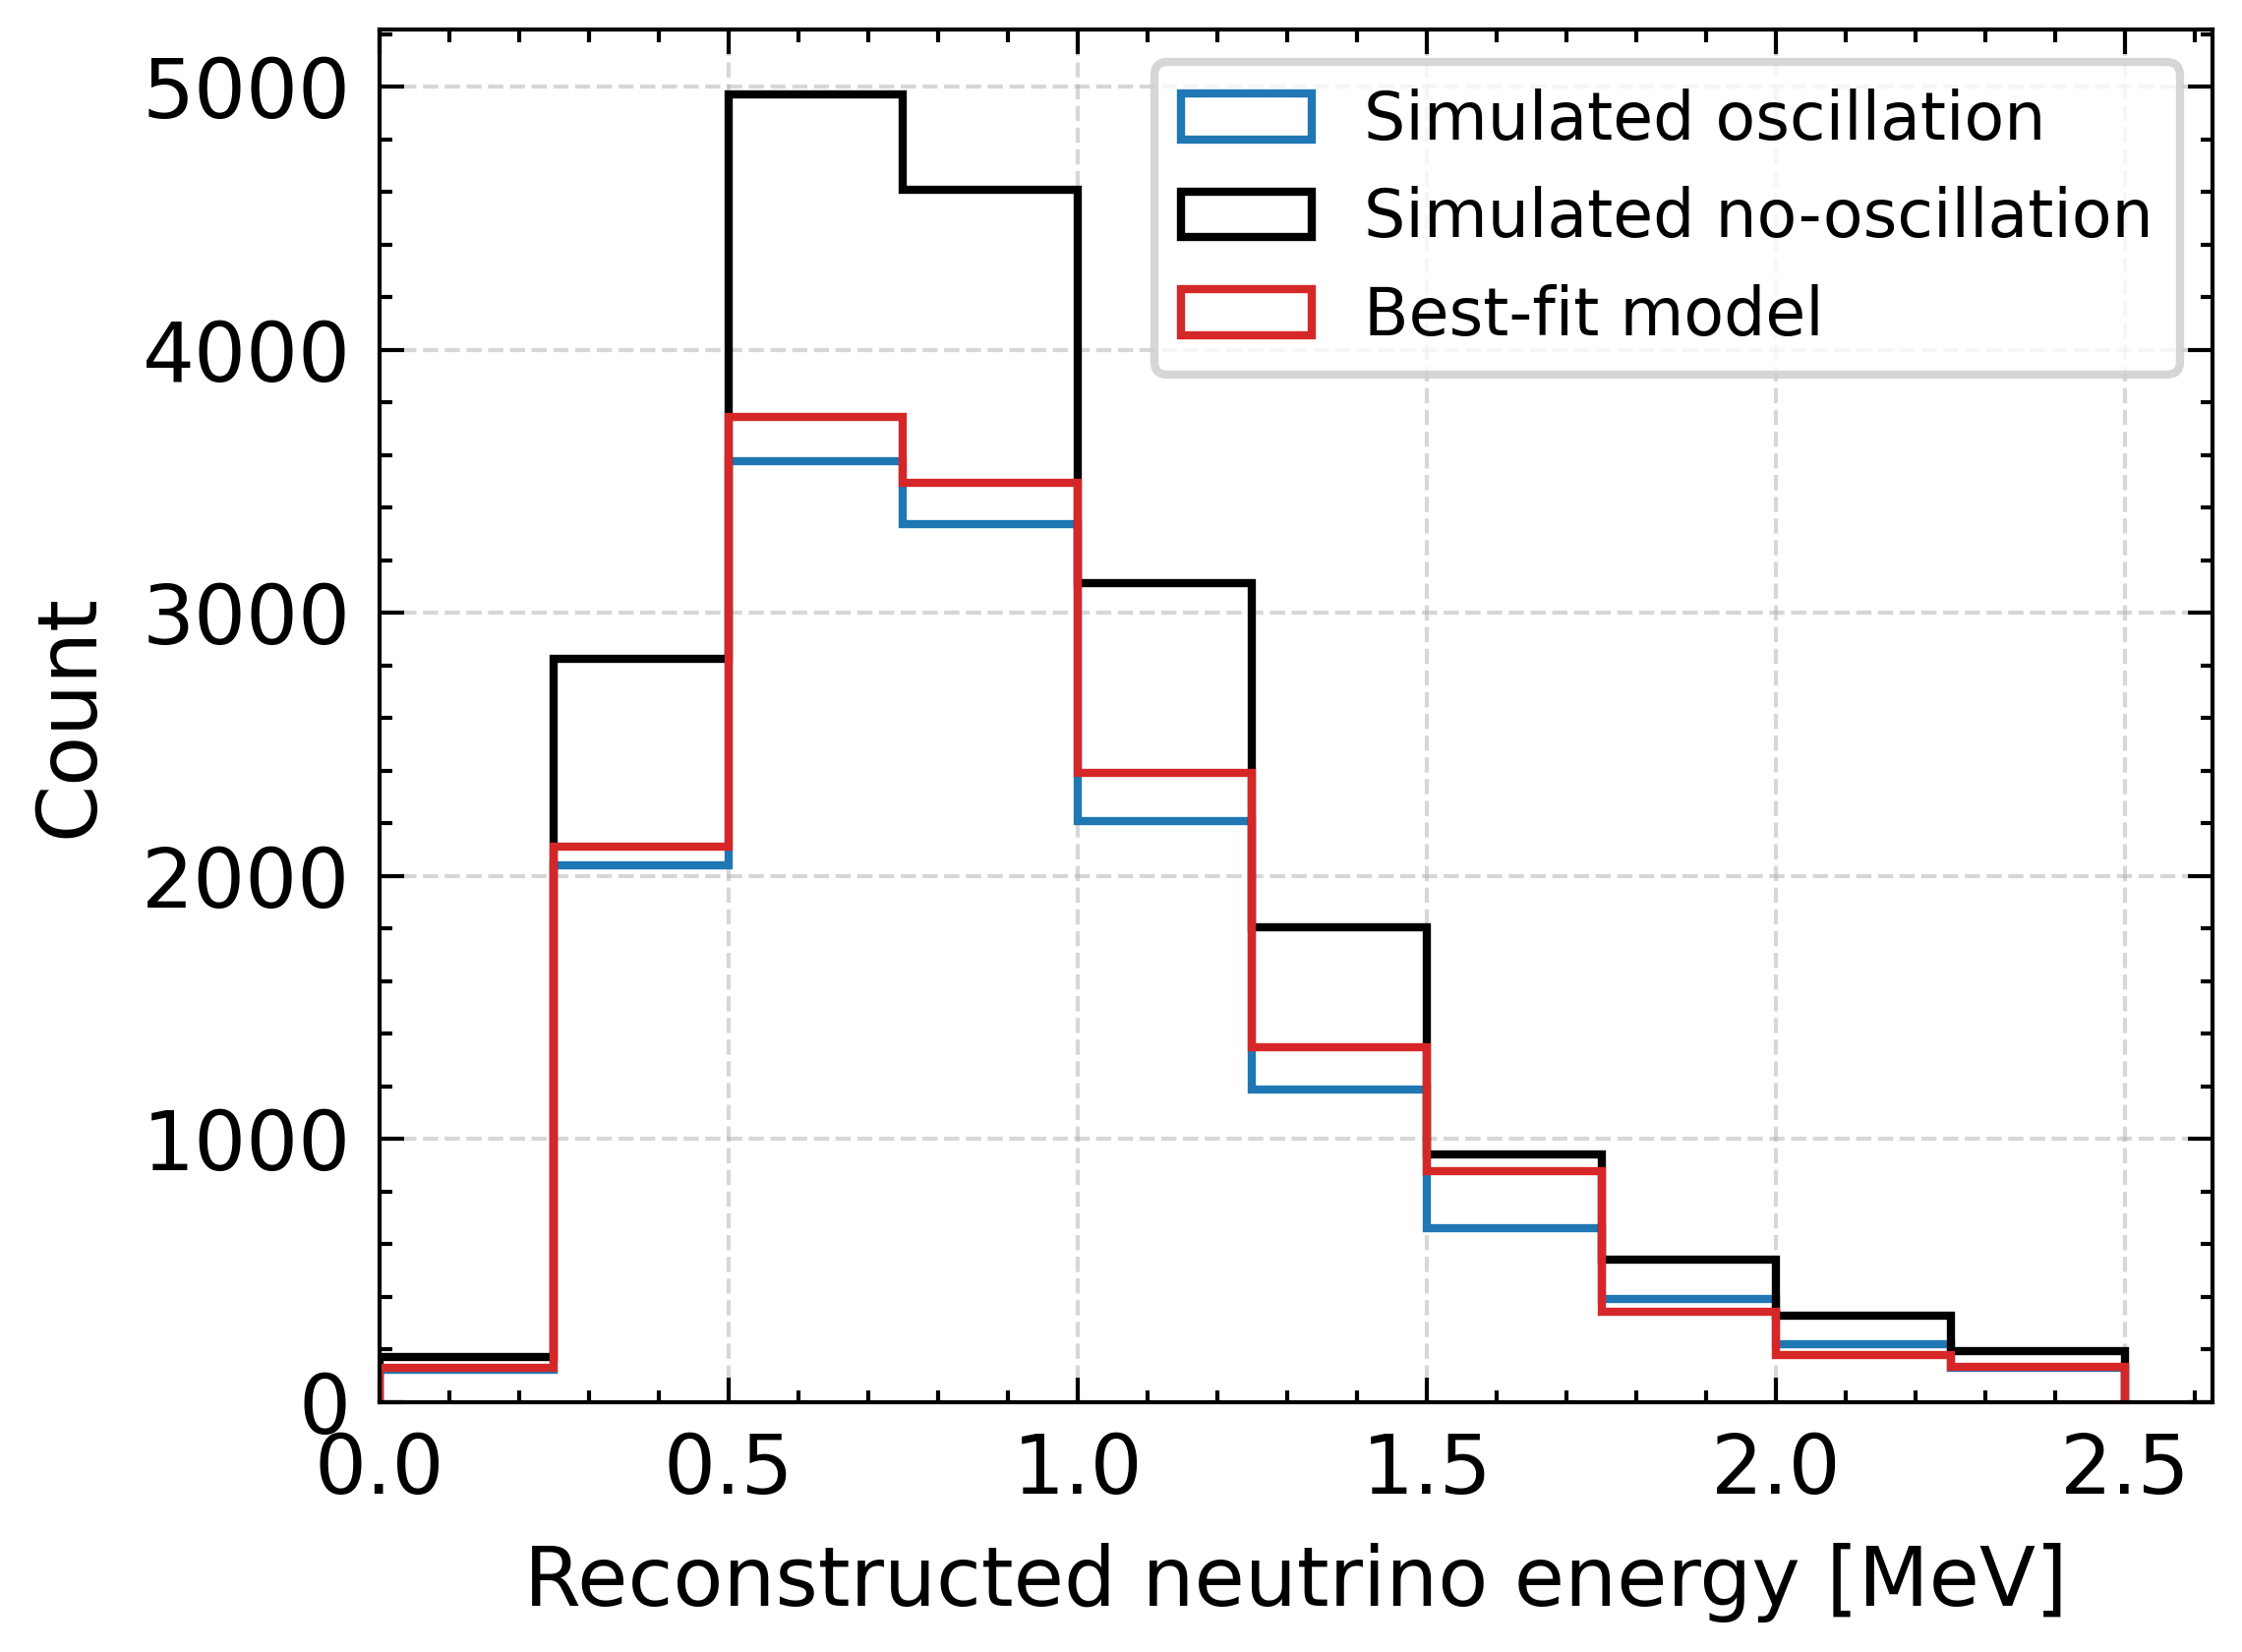

In [13]:
with open('../MicroBooNE/OscillatedSimulation.pkl', 'rb') as infile:
    data_osc = pickle.load(infile)

with open('../MicroBooNE/Simulation.pkl', 'rb') as infile:
    data = pickle.load(infile)

# -----------------------------------
# 1. Oscillating histogram
# -----------------------------------
osc_mask = ((data_osc['Simulation category'] == 21) & (data_osc['Total energy'] < 10) & (data_osc['Simulated neutrino flight distance'] > 100))
osc_signal = data_osc[osc_mask]
osc_weight = osc_signal['Simulation weight']
osc_energy = osc_signal['Total energy']

# Need to apply the cuts too
E_bin = np.linspace(0, 2.5, 11)

osc_count, edges = np.histogram(osc_energy, bins=E_bin, weights=osc_weight)
centers = 0.5*(edges[:-1] + edges[1:])

# only include bins with nonzero experimental counts
valid = osc_count > 0
exp_fit = osc_count[valid]
E_valid = centers[valid]
sigma = np.sqrt(exp_fit+(0.15*exp_fit)**2) 

# -----------------------------------
# 2. Un-oscillated simulation histogram 
# -----------------------------------
no_osc_mask = ((data['Simulation category'] == 21) & (data['Total energy'] < 10) & (data['Simulated neutrino flight distance'] > 100))
no_osc_sel = data[no_osc_mask]
no_osc_weight = no_osc_sel['Simulation weight'] 
no_osc_energy = no_osc_sel['Total energy']
no_osc_count, _ = np.histogram(no_osc_energy, bins=E_bin, weights=no_osc_weight)

# -----------------------------------
# 3. curve_fit model 
# -----------------------------------

def oscillation_model(_, sin2, dm2):
     P = calculate_prob(sin2, dm2, 0.47, no_osc_energy)
     model_count, _ = np.histogram(no_osc_energy, bins=E_bin, weights=no_osc_weight*P)
     return model_count[valid]

# -----------------------------------
# 4. Perform fit
# -----------------------------------
p0 = [0.4, 14]  
popt, pcov = curve_fit(oscillation_model, E_valid, exp_fit, p0=p0, sigma=sigma, absolute_sigma=True,
                      bounds=([0, 0.1], [1, 1000]))
sin2_best, dm2_best = popt
sin2_err, dm2_err = np.sqrt(np.diag(pcov))

print("Best-fit sin²:", sin2_best, "±", sin2_err)
print("Best-fit Δm²:", dm2_best, "±", dm2_err)
best_fit = oscillation_model(E_valid, *popt) 
residual = exp_fit - best_fit
chi2 = np.sum( (residual/sigma)**2 ) 
ndf = len(exp_fit) - len(popt)
print("χ²:", chi2) 
print("ndf:", ndf) 
print("Reduced χ²:", chi2 / ndf)

# -----------------------------------
# 5. Plot
# -----------------------------------
plt.figure(dpi=600, figsize=(4,3))

ax1 = plt.gca()

ax1.hist(osc_energy, bins=E_bin, weights=osc_weight, color='tab:blue',
         label='Simulated oscillation', histtype='step')
ax1.hist(no_osc_energy, bins=E_bin, weights=no_osc_weight, color='black', 
         label='Simulated no-oscillation', histtype='step')
ax1.hist(no_osc_energy, bins=E_bin, weights=no_osc_weight*calculate_prob(popt[0],popt[1], 0.47, no_osc_energy), 
         color='tab:red', label='Best-fit model', histtype='step')


ax1.set_xlabel('Reconstructed neutrino energy [MeV]')
ax1.set_ylabel('Count')
ax1.legend()
ax1.set_ylim(0, None)
ax1.set_xlim(0, None)

ax1.set_xlabel('Reconstructed neutrino energy [MeV]')
ax1.set_ylabel('Count')
ax1.legend(fontsize=8, frameon=True)
ax1.grid(alpha=0.5, linestyle='--')

plt.tight_layout()
plt.show()


In [14]:
len(exp_fit)

10

In [15]:
best_fit

array([ 128.93444484, 2109.68739355, 3743.52062176, 3495.78415069,
       2389.57823514, 1349.25527592,  876.59975323,  340.80594752,
        175.89311245,  132.1874179 ])

# Chi squared via grid search

In [16]:
# -----------------------------------
# Parameter grid
# -----------------------------------
sin2_grid = np.logspace(-2, 0, 100)
dm2_grid = np.logspace(-1, 2, 100)

chi2_map = np.zeros((len(sin2_grid), len(dm2_grid)))

best_chi2 = np.inf
best_params = (None, None)

# -----------------------------------
# Grid search
# -----------------------------------
for i, s in enumerate(sin2_grid):
    for j, d in enumerate(dm2_grid):
        P = calculate_prob(s, d, 0.47, no_osc_energy)
        model_full, _ = np.histogram(no_osc_energy, bins=E_bin,
                                     weights=no_osc_weight * P)
        model = model_full[valid]

        chi2 = np.sum(((exp_fit - model) / sigma)**2)
        chi2_map[i, j] = chi2

        if chi2 < best_chi2:
            best_chi2 = chi2
            best_params = (s, d)

sin2_best, dm2_best = best_params
print("Best sin2:", sin2_best)
print("Best dm2:", dm2_best)
print("Chi2:", best_chi2)
print("Reduced:", best_chi2 / (len(exp_fit) - 2))

# -----------------------------------
# Best-fit model for plotting
# -----------------------------------
P_best = calculate_prob(sin2_best, dm2_best, 0.47, no_osc_energy)
best_full, _ = np.histogram(no_osc_energy, bins=E_bin,
                            weights=no_osc_weight * P_best)

Best sin2: 0.572236765935022
Best dm2: 70.54802310718645
Chi2: 0.5191561977891876
Reduced: 0.06489452472364846


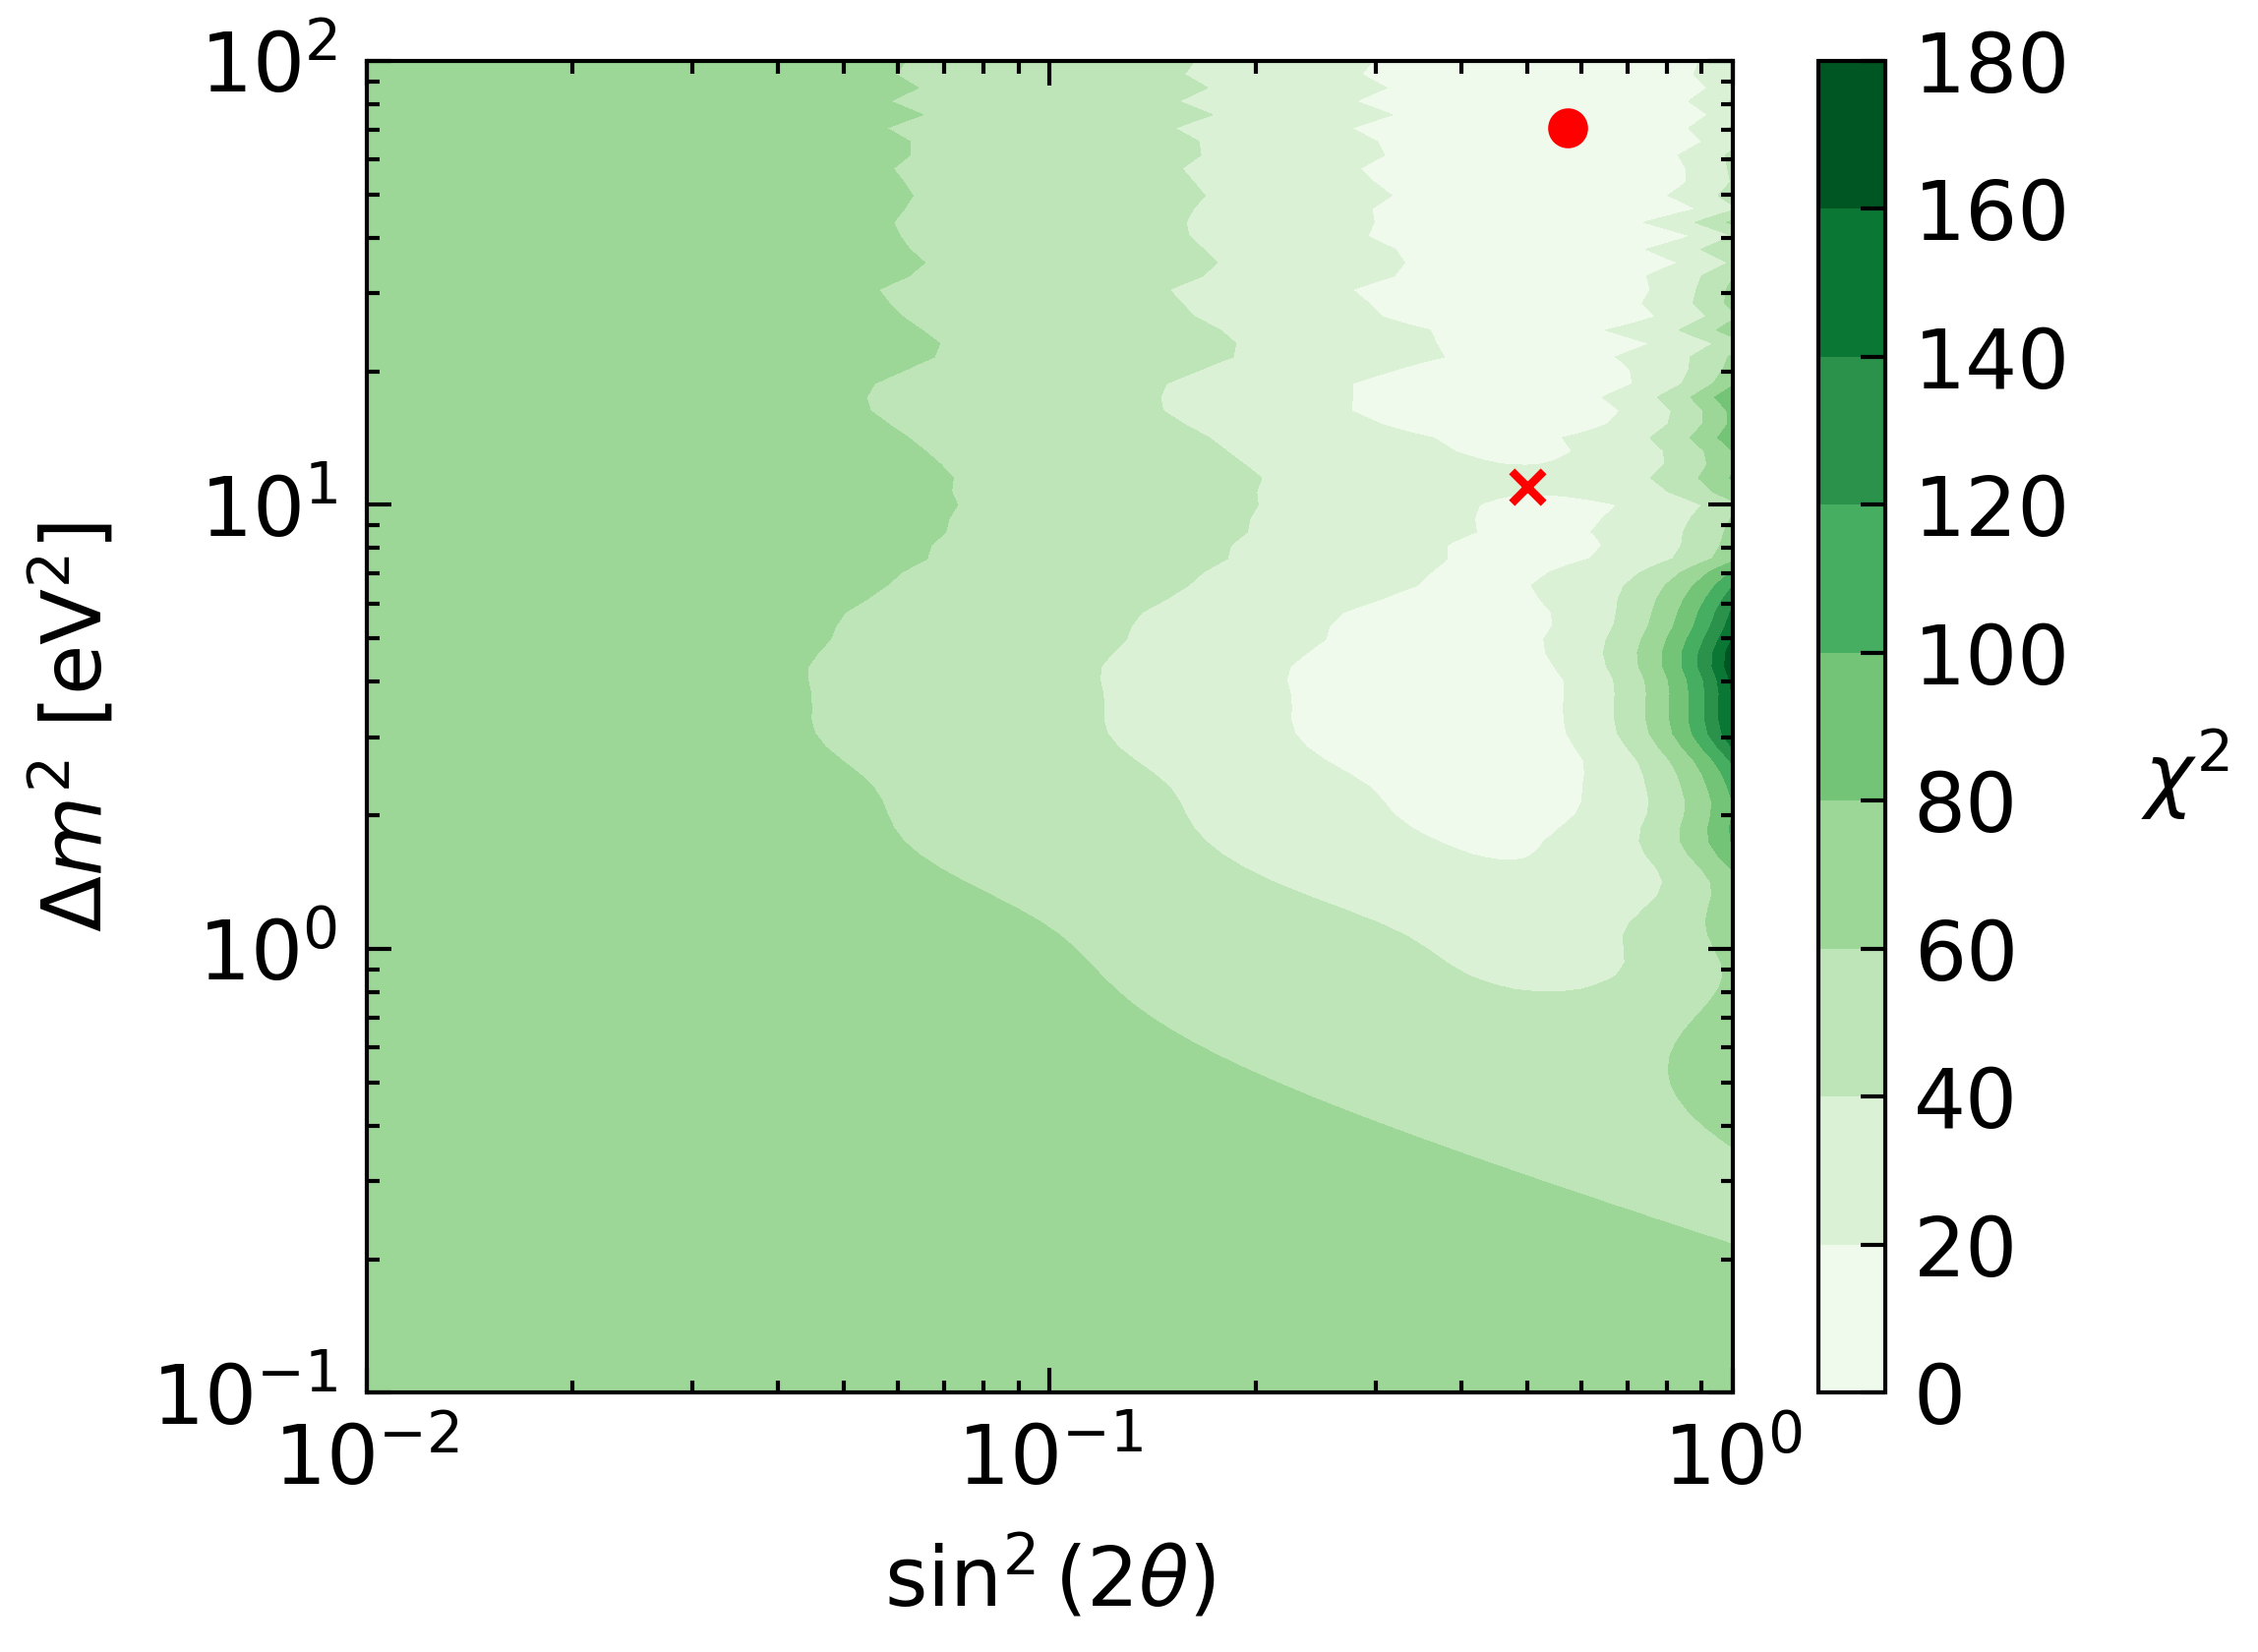

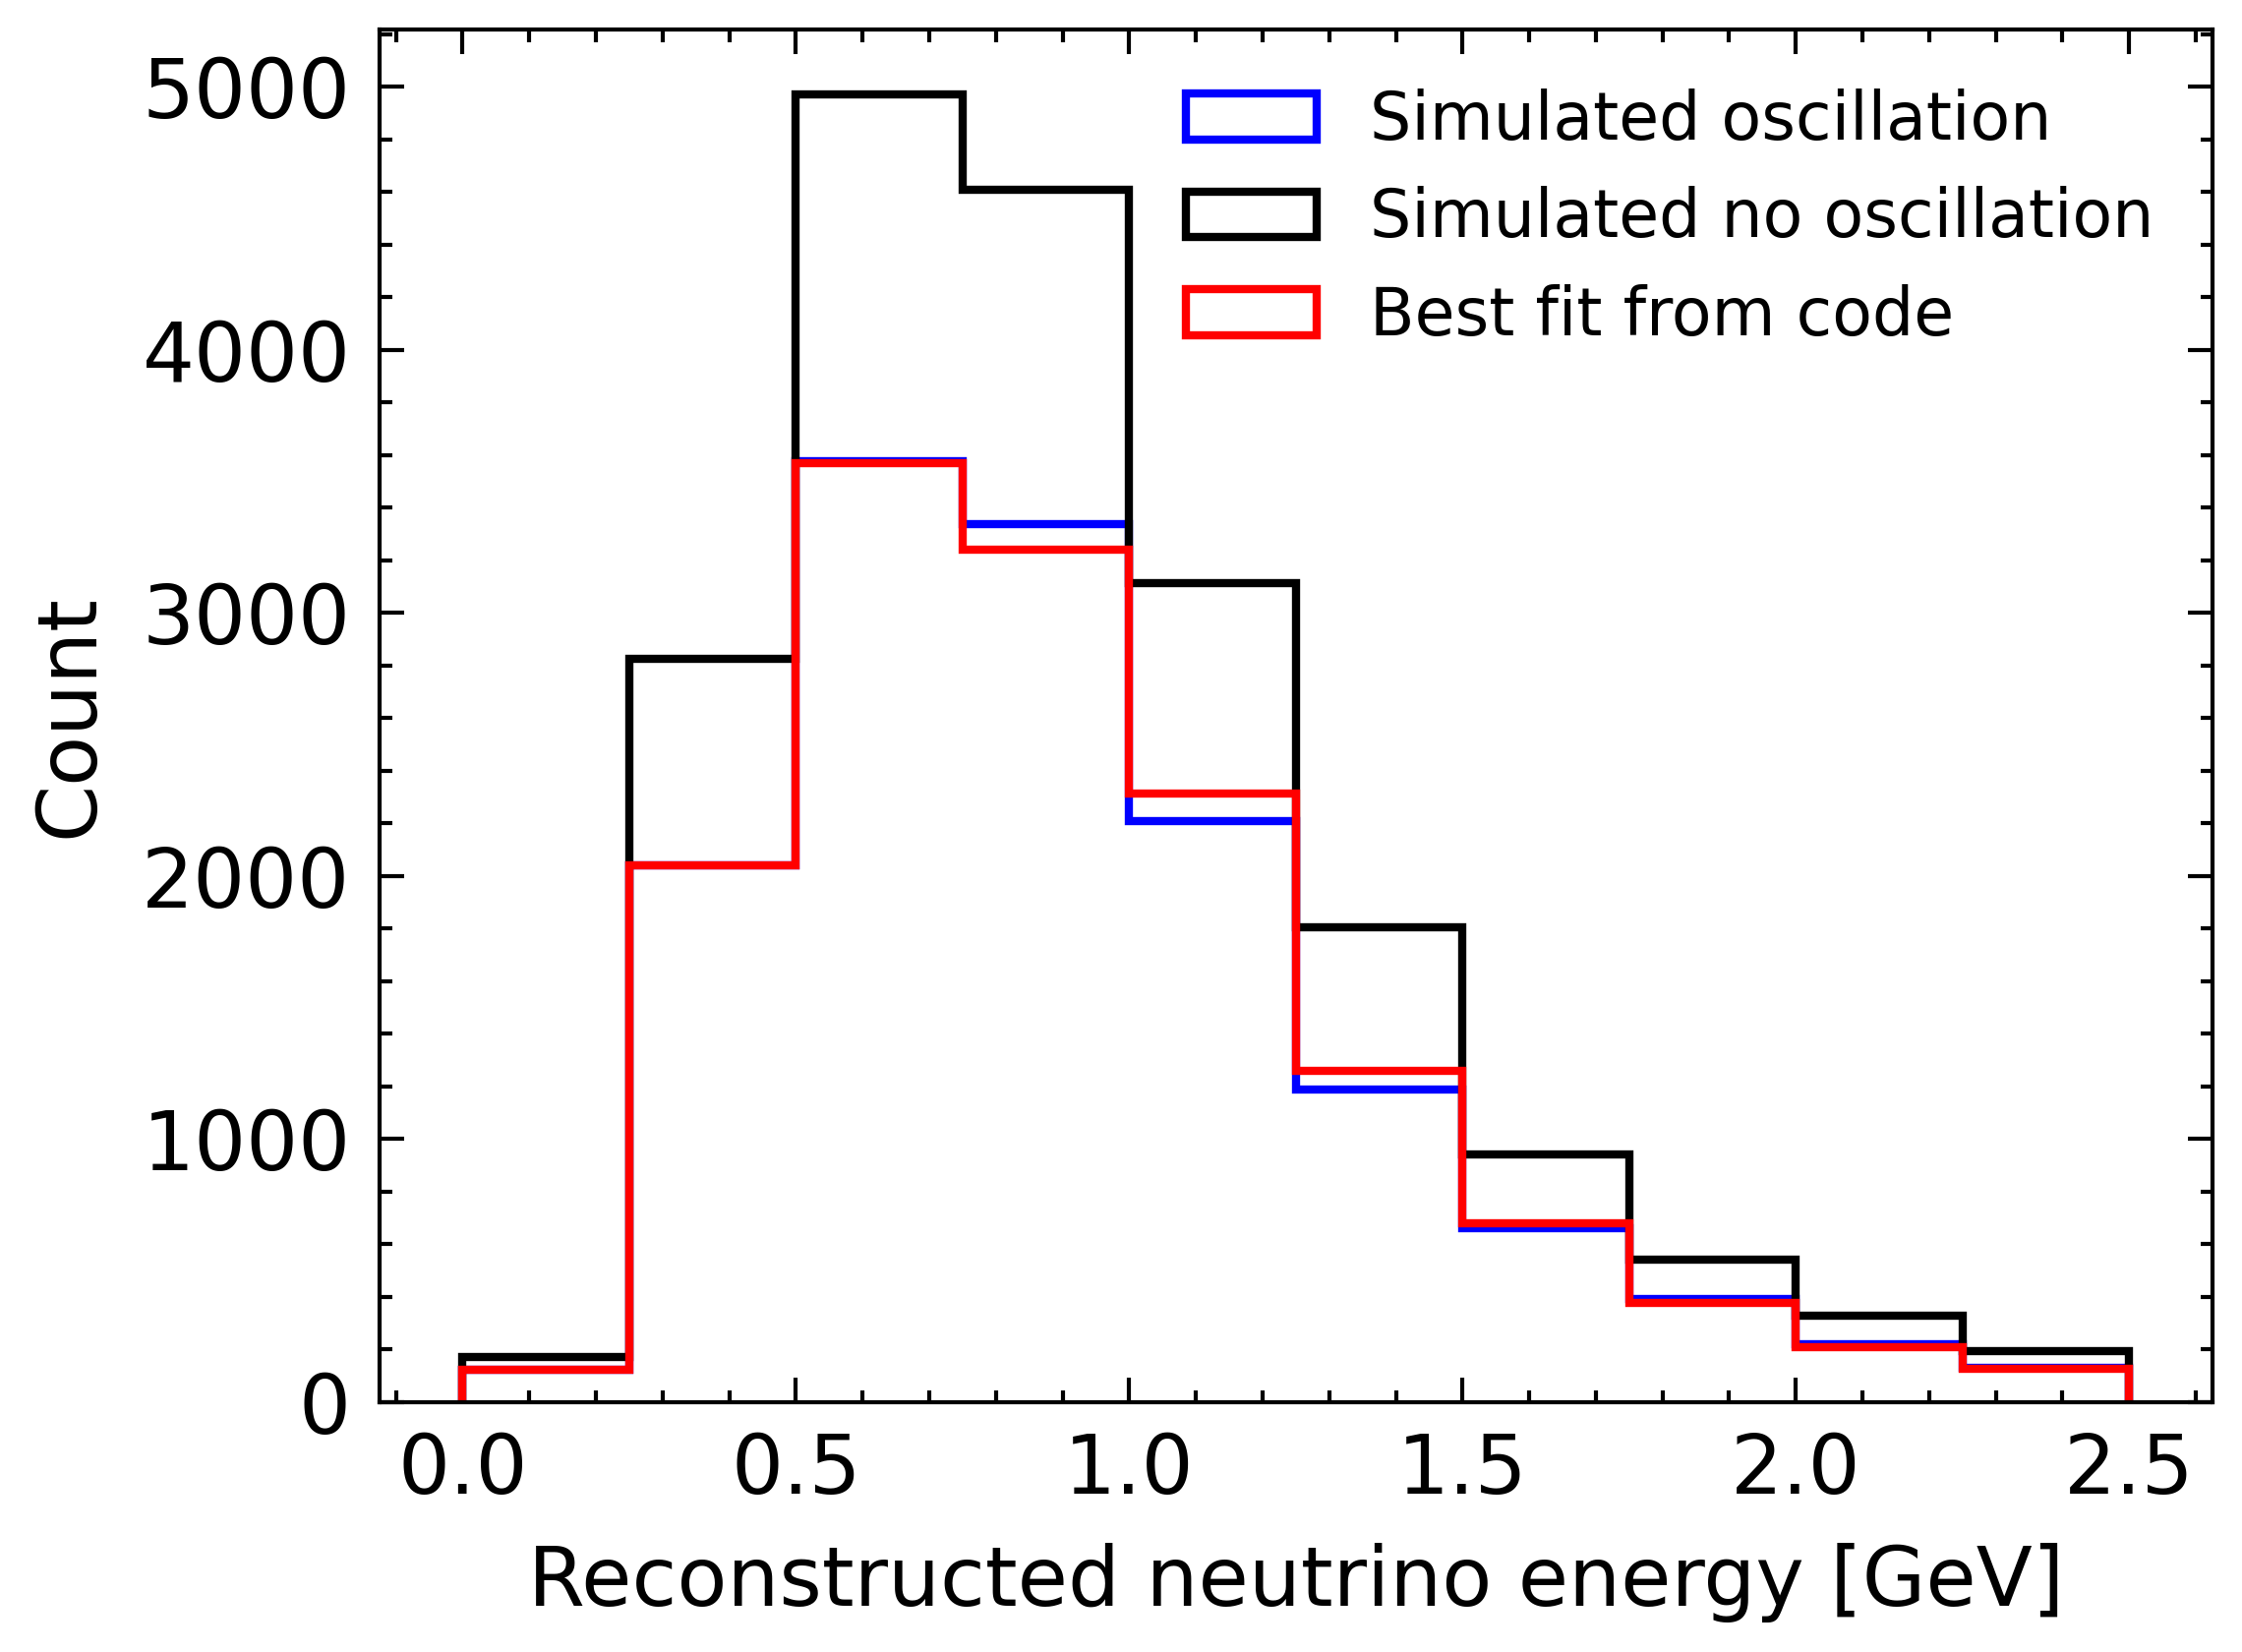

In [17]:
# -----------------------------------
# Plot chi2 map (contour)
# -----------------------------------
plt.figure(dpi=600, figsize=(4,3))

X, Y = np.meshgrid(sin2_grid, dm2_grid, indexing='ij')

levels = 8
cs = plt.contourf(X, Y, chi2_map, levels=levels, cmap='Greens')
cbar = plt.colorbar(cs)
cbar.set_label(r'$\chi^2$', labelpad=14, rotation=0)

plt.scatter(sin2_best, dm2_best, color='red', s=15, marker='o', label='Code Best Fit')
plt.scatter(0.5, 11, color='red', s=15, marker='x', label='Expected Best Fit')

plt.xlabel(r'$\sin^2(2\theta)$')
plt.ylabel(r'$\Delta m^2\ [\mathrm{eV}^2]$')
plt.xscale('log')
plt.yscale('log')

plt.tight_layout()
plt.show()

# -----------------------------------
# Plot histograms
# -----------------------------------
plt.figure(dpi=600, figsize=(4,3))
ax1 = plt.gca()

P = calculate_prob(0.5,11,0.47, no_osc_energy)

ax1.hist(osc_energy, bins=E_bin, weights=osc_weight,
         histtype='step', color='blue', label='Simulated oscillation')
ax1.hist(no_osc_energy, bins=E_bin, weights=no_osc_weight,
         histtype='step', color='black', label='Simulated no oscillation')
ax1.hist(no_osc_energy, bins=E_bin,
         weights=no_osc_weight * P_best,
         histtype='step', color='red', label='Best fit from code')
#ax1.hist(no_osc_energy, bins=E_bin,
#         weights=no_osc_weight * P,
#         histtype='step', color='purple', label='Best fit from literature')

ax1.set_xlabel('Reconstructed neutrino energy [GeV]')
ax1.set_ylabel('Count')
ax1.legend(fontsize=8)
plt.tight_layout()
plt.show()


## Select signal in the experimental data

In [25]:
with open('../MicroBooNE/Data.pkl', 'rb') as infile:
    data_exp = pickle.load(infile)

for col in features:
    data_exp[col] = pandas.to_numeric(data_exp[col], errors='coerce')

exp_pass = data_exp[data_exp['Total energy'] < 10].copy()
exp_pass['ML_score'] = model.predict_proba(exp_pass[features])[:, 1]

signal_exp = exp_pass[exp_pass['ML_score'] > 0.7]
background_exp = exp_pass[exp_pass['ML_score'] <= 0.7]

print(len(signal_exp), len(background_exp))


22297 7423


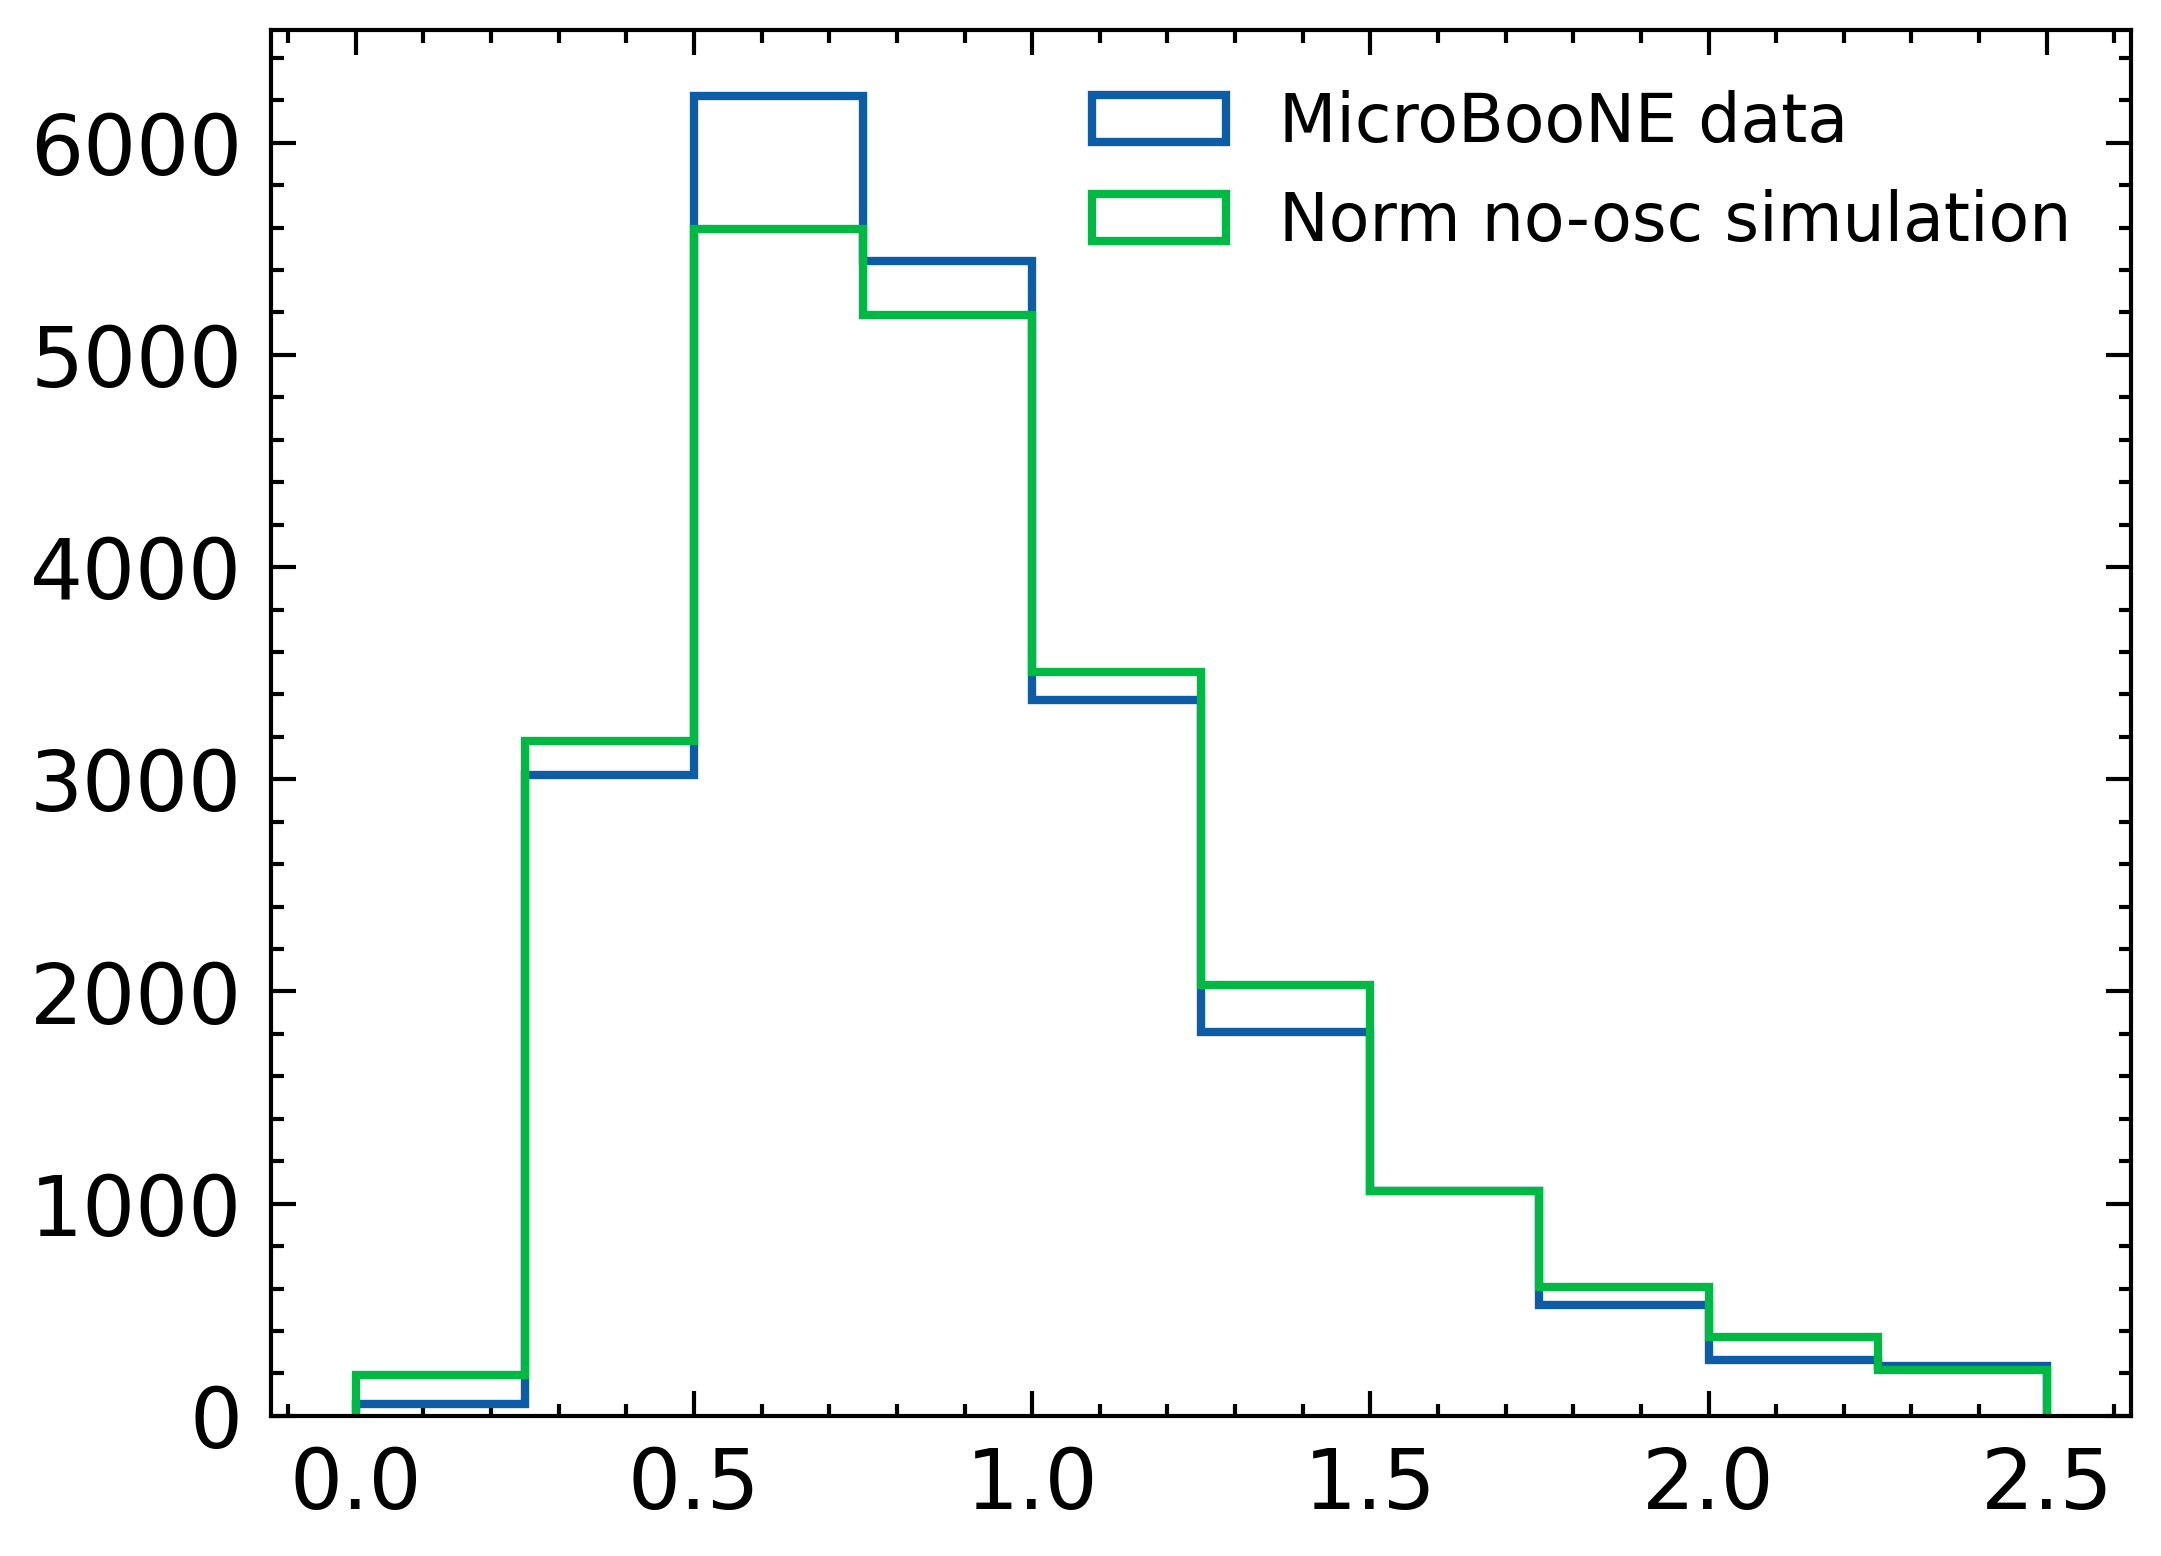

In [54]:
plt.figure(dpi=600, figsize=(4,3))

N_exp  = len(signal_exp['Total energy'])
N_sim  = no_osc_weight.sum()
scale = N_exp / N_sim

plot = plt.hist(signal_exp['Total energy'], bins=E_bin, histtype='step', label='MicroBooNE data')
plot2 = plt.hist(no_osc_energy, bins=E_bin, histtype='step', weights=no_osc_weight*scale, label='Norm no-osc simulation')
plt.legend(fontsize=8)

In [70]:
N_exp  = len(signal_exp['Total energy'])
N_sim  = no_osc_weight.sum()
scale = N_exp / N_sim

exp_count, edges = np.histogram(signal_exp['Total energy'], bins=E_bin)
centers = 0.5*(edges[:-1] + edges[1:])

# only include bins with nonzero experimental counts
valid = exp_count > 0
exp_count = exp_count[valid]
E_valid = centers[valid]
sigma = np.sqrt(exp_count + 0.15*(exp_count)**2)
sigma = np.sqrt(exp_count)

# -----------------------------------
# Parameter grid
# -----------------------------------
sin2_grid = np.logspace(-2, 0, 100)
dm2_grid = np.logspace(-1, 2, 100)

chi2_map = np.zeros((len(sin2_grid), len(dm2_grid)))

best_chi2 = np.inf
best_params = (None, None)

# -----------------------------------
# Grid search
# -----------------------------------
for i, s in enumerate(sin2_grid):
    for j, d in enumerate(dm2_grid):
        P = calculate_prob(s, d, 0.47, no_osc_energy)
        model_full, _ = np.histogram(no_osc_energy, bins=E_bin,
                                     weights=no_osc_weight * scale * P)

        chi2 = np.sum(((exp_count - model_full[valid]) / sigma)**2)
        chi2_map[i, j] = chi2

        if chi2 < best_chi2:
            best_chi2 = chi2
            best_params = (s, d)

sin2_best, dm2_best = best_params
print("Best sin2:", sin2_best)
print("Best dm2:", dm2_best)
print("Chi2:", best_chi2)
print("Reduced:", best_chi2 / (len(exp_count) - 2))

# -----------------------------------
# Best-fit model for plotting
# -----------------------------------
P_best = calculate_prob(sin2_best, dm2_best, 0.47, no_osc_energy)
best_full, _ = np.histogram(no_osc_energy, bins=E_bin,
                            weights=no_osc_weight * scale * P_best)

Best sin2: 1.0
Best dm2: 0.23101297000831597
Chi2: 350.7566549378574
Reduced: 43.84458186723217


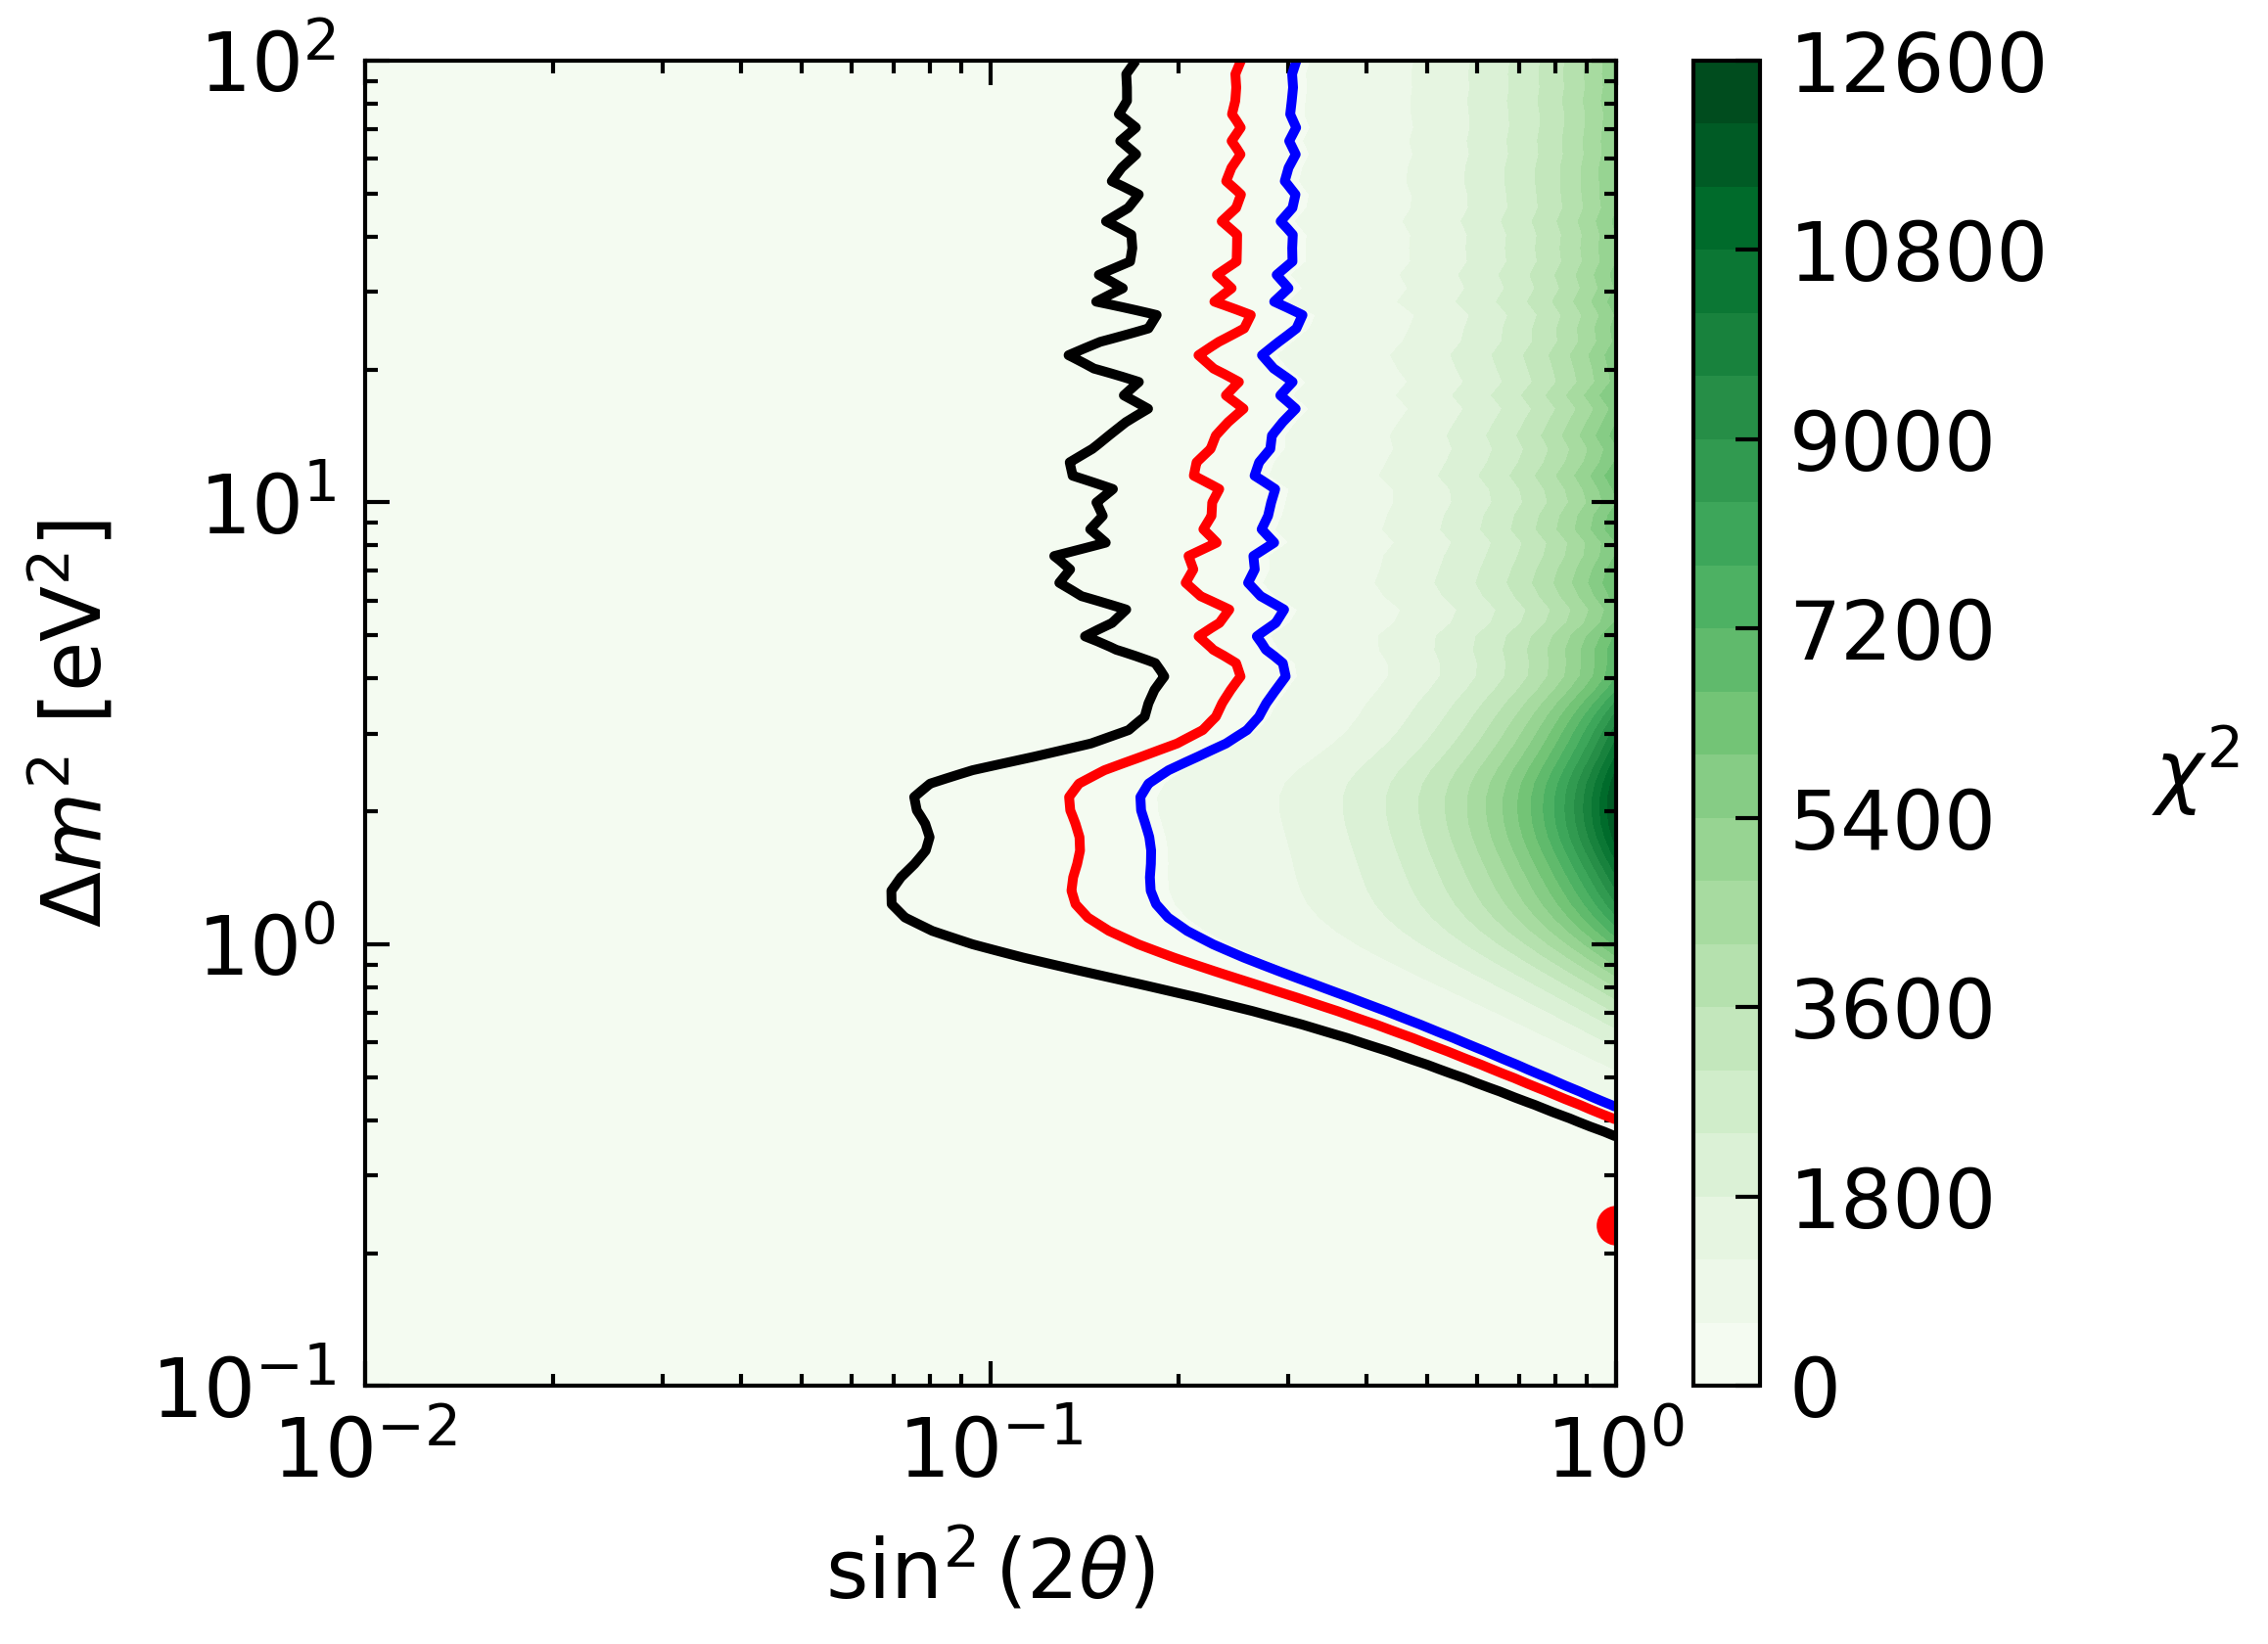

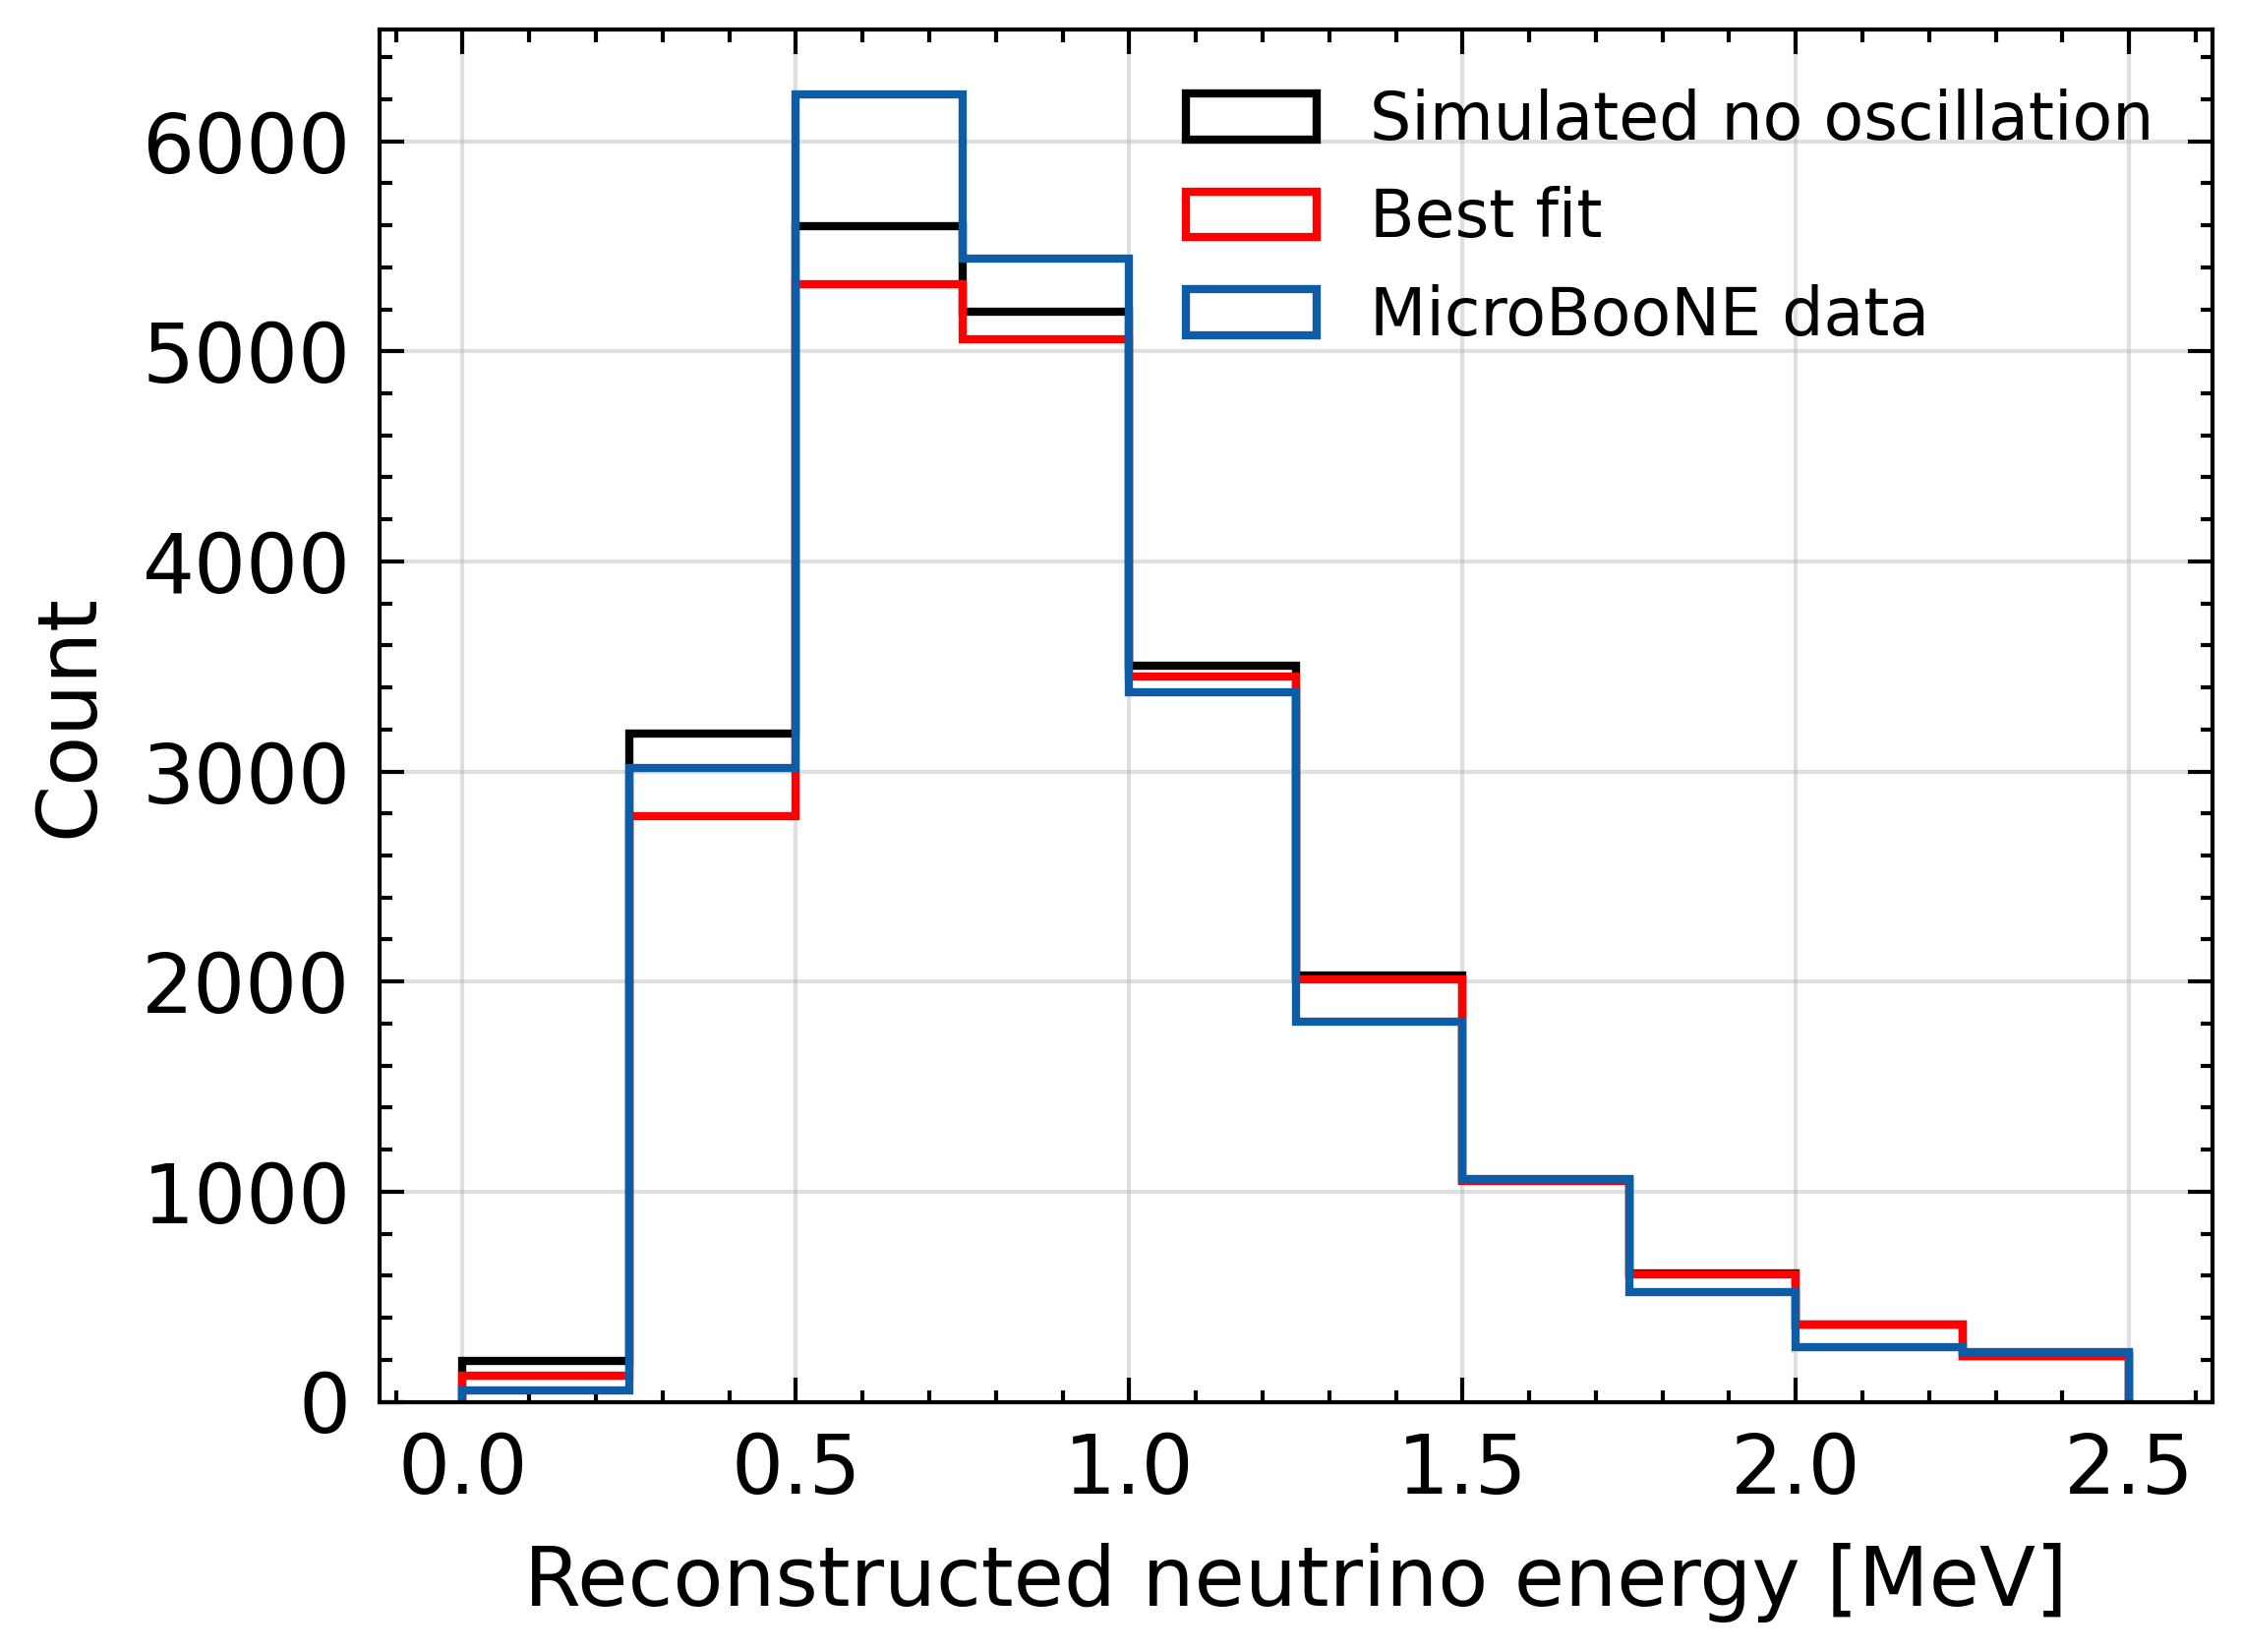

In [100]:
# -----------------------------------
# Plot chi2 map
# -----------------------------------
plt.figure(dpi=600, figsize=(4,3))

relchi2_map = chi2_map - best_chi2

X, Y = np.meshgrid(sin2_grid, dm2_grid, indexing='ij')

cs = plt.contourf(
    X, Y, relchi2_map,
    levels=20,
    cmap='Greens')

cbar = plt.colorbar(cs)
cbar.set_label(r'$\chi^2$', labelpad=18, rotation=0) 

# Confidence level contours
CL_levels = [250, 400, 550]  # 68%, 90%, 95%
cs = plt.contour(
    X, Y, relchi2_map,
    levels=CL_levels,
    colors=['black', 'red', 'blue'],
    linewidths=1.2
)

plt.xlabel(r'$\sin^2(2\theta)$')
plt.ylabel(r'$\Delta m^2\ [\mathrm{eV}^2]$')
plt.scatter(sin2_best, dm2_best, color='red', s=15, marker='o', label='Code Best Fit')
plt.xscale('log')
plt.yscale('log')

plt.tight_layout()
plt.show()


# -----------------------------------
# Plot histograms
# -----------------------------------
plt.figure(dpi=600, figsize=(4,3))
ax1 = plt.gca()

ax1.hist(no_osc_energy, bins=E_bin, weights=no_osc_weight*scale,
         histtype='step', color='black', label='Simulated no oscillation')
ax1.hist(no_osc_energy, bins=E_bin,
         weights=no_osc_weight * scale * P_best,
         histtype='step', color='red', label='Best fit')
ax1.hist(signal_exp['Total energy'], bins=E_bin, histtype='step', label='MicroBooNE data')

ax1.set_xlabel('Reconstructed neutrino energy [MeV]')
ax1.set_ylabel('Count')
ax1.legend(fontsize=8)
ax1.grid(alpha=0.4)
plt.tight_layout()
plt.show()


Best fit point at 0.0825 0.23101297000831597


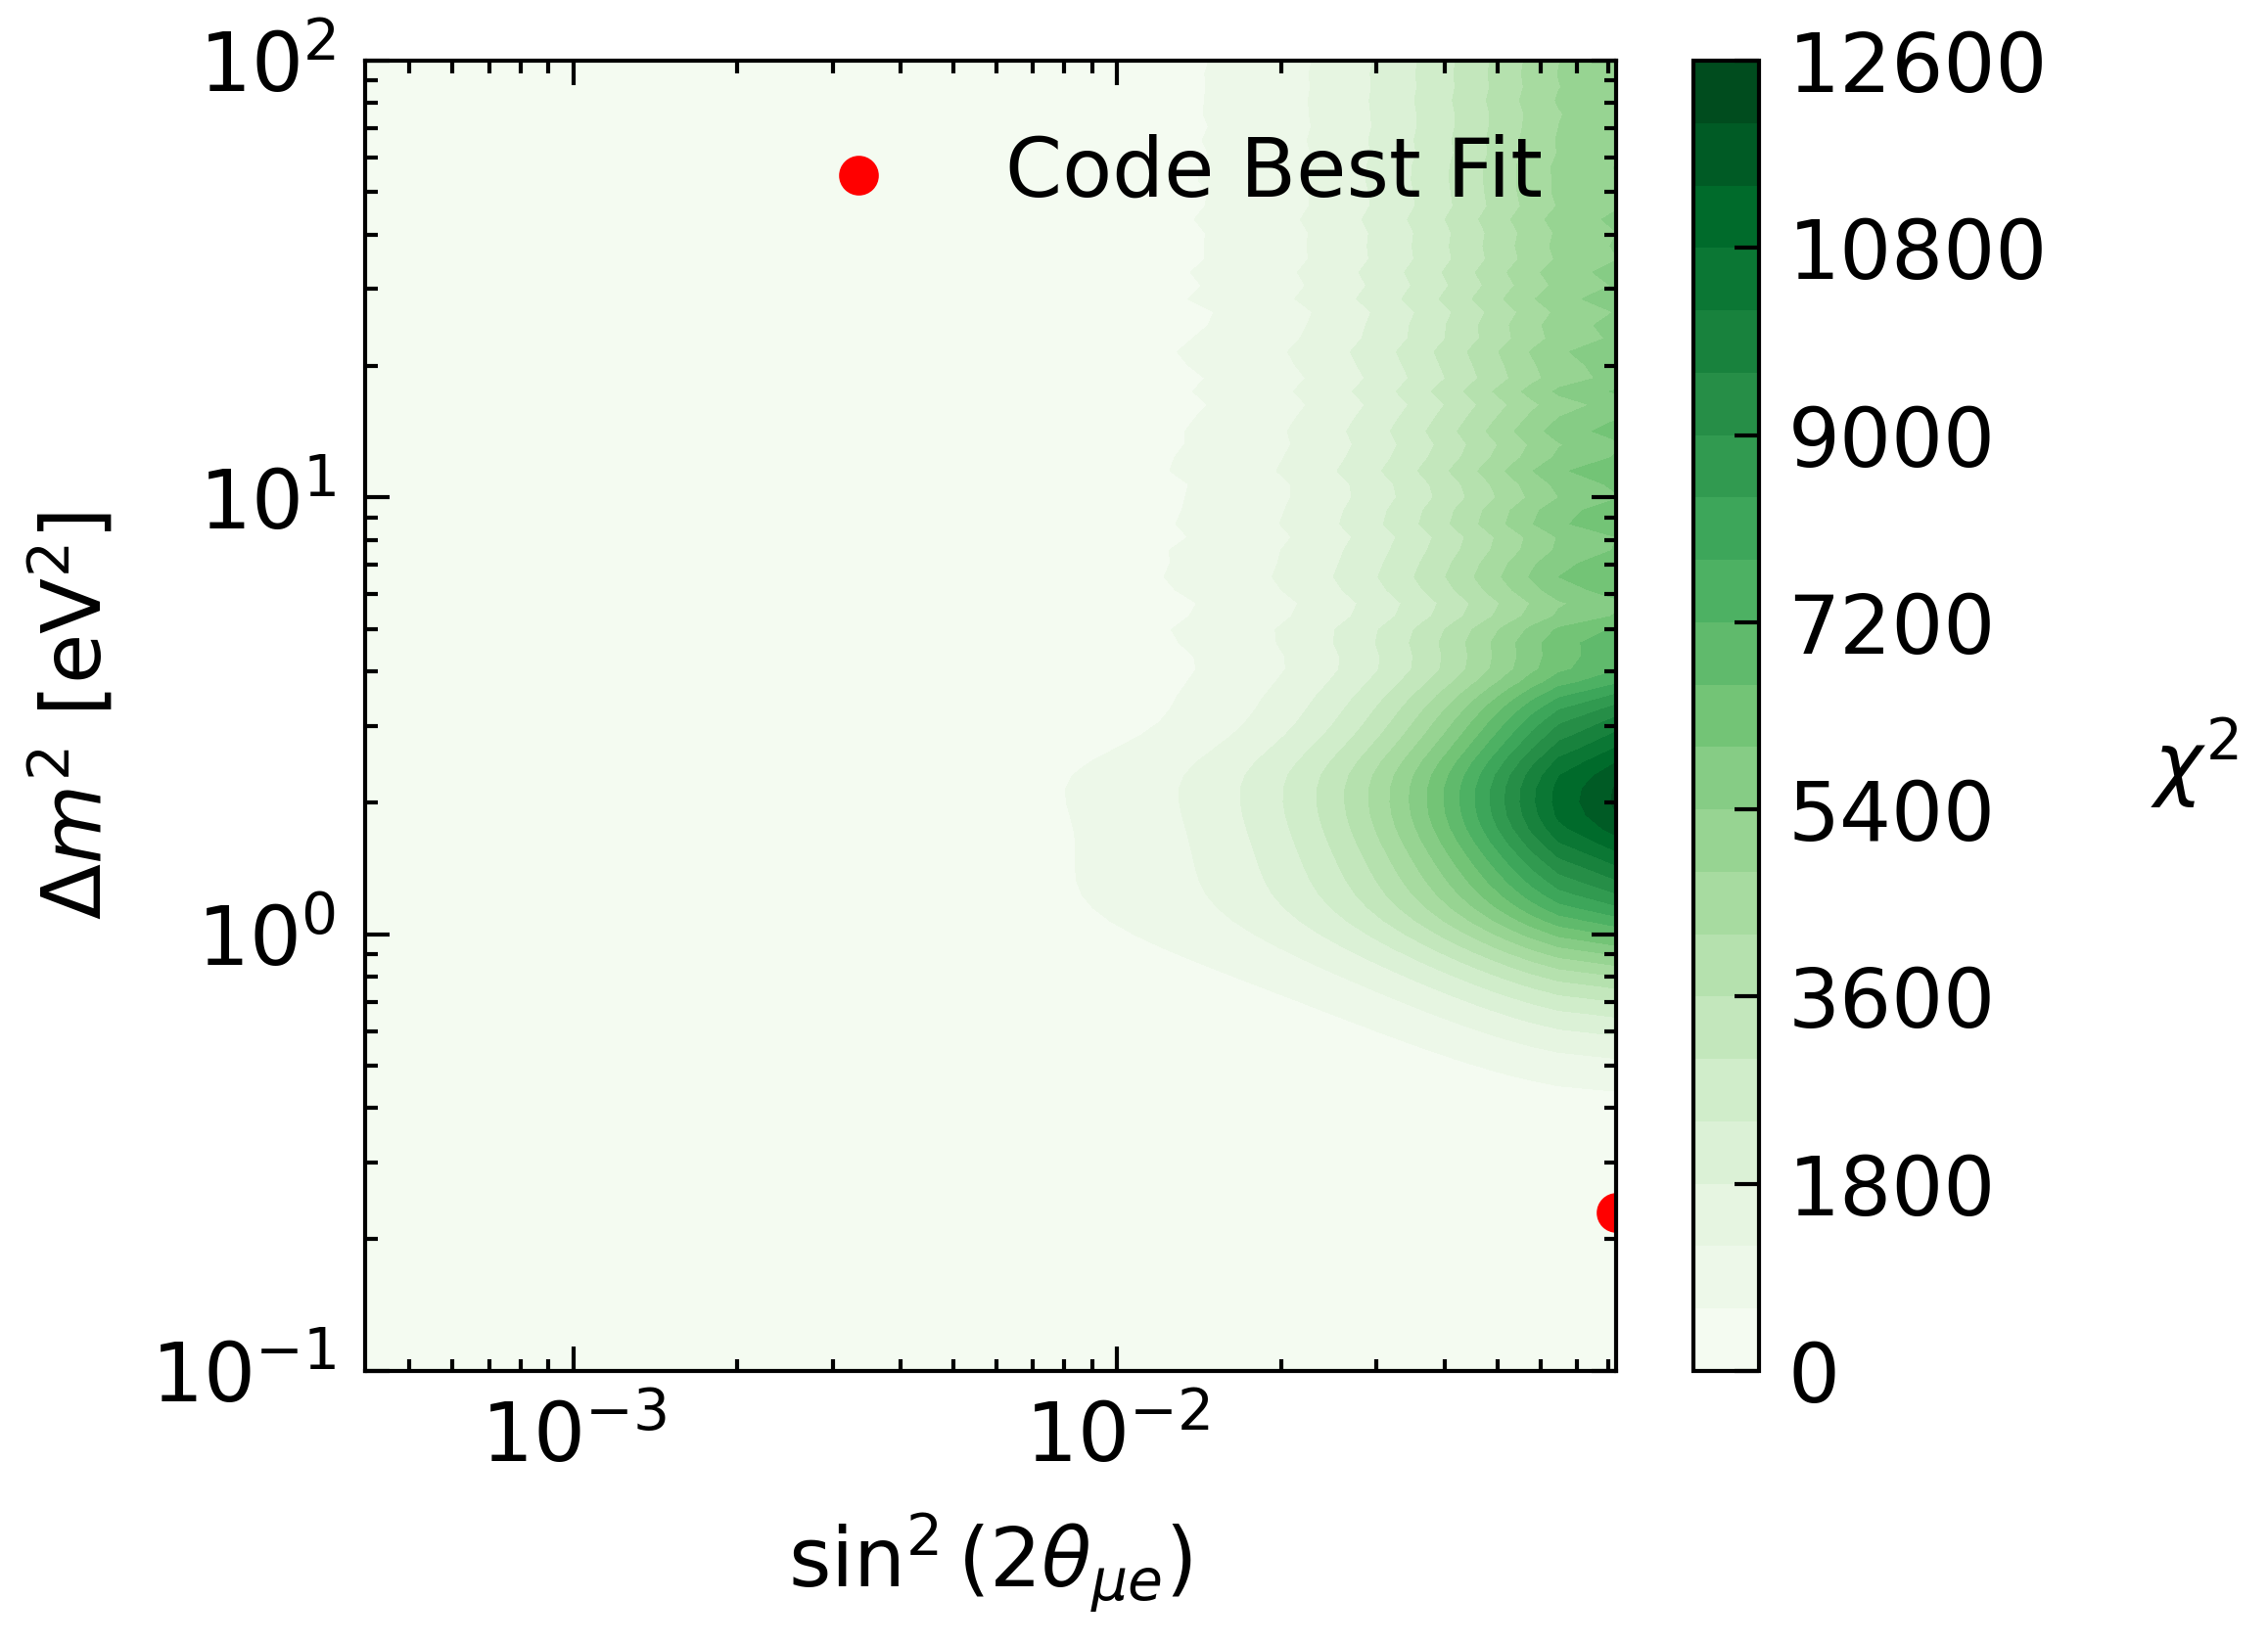

In [82]:
#from PROSPECT paper, we can get sin^2(2theta_14) = 0.165 (paper: A Search for Sterile Neutrinos with PROSPECT)

def sin_mue(sin2_mumu, sin2_ee):
    return sin2_ee * (1 - np.sqrt(1 - sin2_mumu))/2

def sin_mue_exact(sin_mumu, sin2_14):
    x = (1 - np.sqrt(1 - sin_mumu)) / 2      # |U_mu4|^2
    y = (1 - np.sqrt(1 - sin2_14)) / 2       # |U_e4|^2
    return 4 * x * y


sin2_ee = 0.165
sin2_mue_grid = sin_mue(sin2_grid, sin2_ee)

# convert best-fit point too
sin2_mue_best = sin_mue(sin2_best, sin2_ee)

print("Best fit point at", sin2_mue_best, dm2_best)

plt.figure(dpi=600, figsize=(4,3))

X, Y = np.meshgrid(sin2_mue_grid, dm2_grid, indexing='ij')

cs = plt.contourf(X, Y, relchi2_map, levels=20, cmap='Greens')

cbar = plt.colorbar(cs)
cbar.set_label(r'$\chi^2$', labelpad=18, rotation=0)

plt.xlabel(r'$\sin^2(2\theta_{\mu e})$')
plt.ylabel(r'$\Delta m^2\ [\mathrm{eV}^2]$')

plt.scatter(sin2_mue_best, dm2_best, color='red', s=15, marker='o', label='Code Best Fit')

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()


In [65]:
np.max(sin2_mue_grid)

0.0825